# Now lets pull in our user level metrics and grouped metrics tables and create final views

In [132]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [133]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    metrics_tables = [table[0] for table in tables]
    latest_metrics_table = sorted(metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(df)} rows and {len(df.columns)} columns")
    print("\nDataFrame shape:", df.shape)
    print("\nColumn names:", list(df.columns))
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Show summary statistics for key metrics columns
    print("\nKey metrics summary:")
    metric_columns = ['payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'current_mrr']
    print(df[metric_columns].describe())

# Close the connection
conn.close()

Loading data from the most recent metrics table: 'metrics_subscription_data_20230116'

Loaded 134610 rows and 21 columns

DataFrame shape: (134610, 21)

Column names: ['oid', 'provider', 'total_charges', 'signup_date', 'is_canceled', 'is_active', 'is_delinquent', 'conversion_date', 'cancellation_date', 'current_mrr', 'personal_person_geo_country', 'converted', 'payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'price_tier', 'conversion_speed', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort']

First 5 rows:
               oid provider  total_charges          signup_date  is_canceled  \
0  273624174263463    apple          10.94  2021-04-20 00:00:00            1   
1  532534633483904    apple          10.92  2021-04-20 00:00:00            1   
2  623527156674739    apple           0.00  2021-04-20 00:00:00            0   
3  441616357320658    apple          90.30  2021-04-20 00:00:00            0   
4  189644194376891    apple          79.98  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [134]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'grouped_metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    grouped_metrics_tables = [table[0] for table in tables]
    grouped_latest_metrics_table = sorted(grouped_metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{grouped_latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {grouped_latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    grouped_df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(grouped_df)} rows and {len(grouped_df.columns)} columns")
    print("\nDataFrame shape:", grouped_df.shape)
    print("\nColumn names:", list(grouped_df.columns))
    print("\nFirst 5 rows:")
    print(grouped_df.head())
    
    

# Close the connection
conn.close()

Loading data from the most recent metrics table: 'grouped_metrics_subscription_data_2023_01'

Loaded 16025 rows and 18 columns

DataFrame shape: (16025, 18)

Column names: ['provider', 'is_active', 'is_canceled', 'converted', 'personal_person_geo_country', 'price_tier', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort', 'customer_count', 'total_charges_sum', 'avg_total_charges', 'avg_current_mrr', 'avg_payment_periods', 'avg_of_avg_monthly_payment', 'sum_avg_monthly_payment', 'avg_expansion_ratio', 'avg_conversion_speed']

First 5 rows:
  provider  is_active  is_canceled  converted personal_person_geo_country  \
0    apple          1            0          1    United States of America   
1    apple          1            0          1    United States of America   
2    apple          1            0          1    United States of America   
3    apple          1            0          1    United States of America   
4    apple          1            0          1    United 

### Lets look at performance and retention across the starting cohorts
- Focus on this type of view moving forward by different grouped by pivots

- Lets first look at how current MRR and average monthly payment (total charges / number of payment periods) vary across buckets

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/1825124326.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_mrr_by_tenure = expansion_df.groupby(period_ranges).agg({


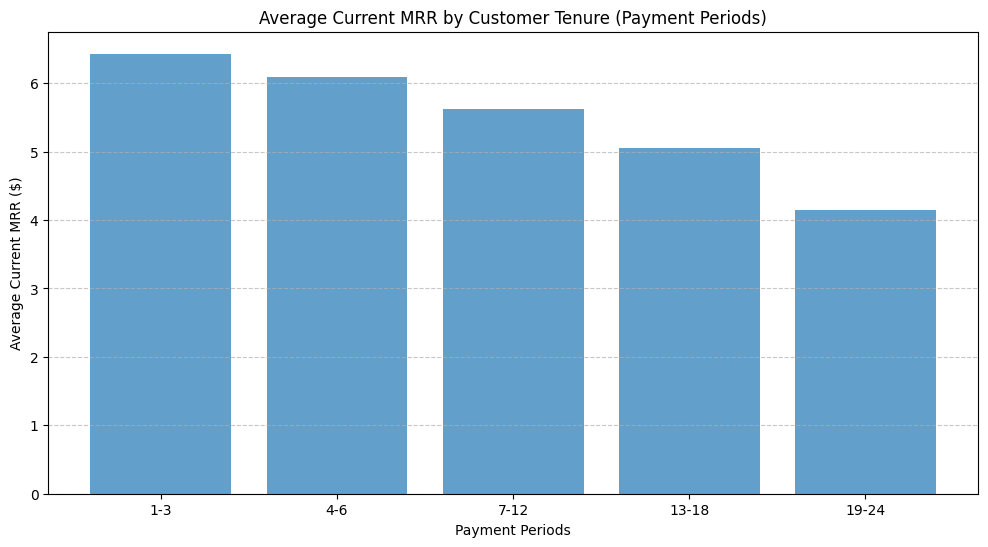

In [135]:
# Filter for customers with enough history to potentially show expansion
expansion_df = df[(df['converted'] == 1) & (df['is_canceled'] == 0)]

# Group by payment period ranges to see MRR patterns
period_ranges = pd.cut(expansion_df['payment_periods'], 
                      bins=[0, 3, 6, 12, 18, 24, 36, 100],
                      labels=['1-3', '4-6', '7-12', '13-18', '19-24', '25-36', '37+'])

avg_mrr_by_tenure = expansion_df.groupby(period_ranges).agg({
    'current_mrr': 'mean',
    'oid': 'count'
}).reset_index()

# Plot to see if MRR increases with longer customer tenure
plt.figure(figsize=(12, 6))
plt.bar(avg_mrr_by_tenure['payment_periods'], avg_mrr_by_tenure['current_mrr'], alpha=0.7)
plt.title('Average Current MRR by Customer Tenure (Payment Periods)')
plt.xlabel('Payment Periods')
plt.ylabel('Average Current MRR ($)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

### Above tells us that either we are originating with higher MRR as time goes on or that the higher MRR customers are downgrading/canceling service at larger rate than other customers

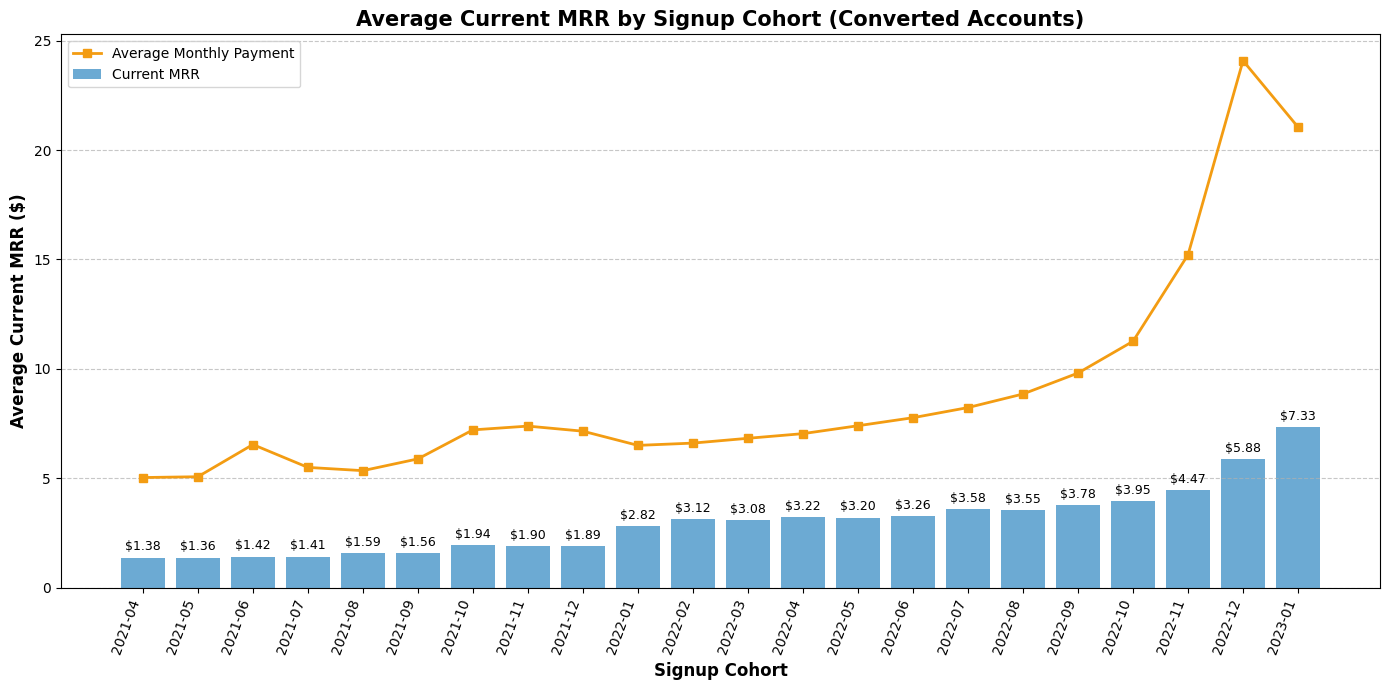

In [136]:
# Filter for converted customers
converted_df = df[df['converted'] == 1]

# Group by signup cohort to see MRR patterns
avg_mrr_by_cohort = converted_df.groupby('signup_cohort').agg({
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',  # Including this for comparison
    'oid': 'count'
}).reset_index()

# Sort by cohort chronologically
avg_mrr_by_cohort = avg_mrr_by_cohort.sort_values('signup_cohort')

# Plot to see if MRR changes by signup cohort
plt.figure(figsize=(14, 7))

# Create the bar chart for current MRR
bars = plt.bar(avg_mrr_by_cohort['signup_cohort'], avg_mrr_by_cohort['current_mrr'], 
               alpha=0.7, color='#2E86C1', label='Current MRR')

# Add a line for average monthly payment
plt.plot(avg_mrr_by_cohort['signup_cohort'], avg_mrr_by_cohort['avg_monthly_payment'], 
         's-', color='#F39C12', linewidth=2, label='Average Monthly Payment')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
            f'${height:.2f}', ha='center', va='bottom', fontsize=9)

plt.title('Average Current MRR by Signup Cohort (Converted Accounts)', fontsize=15, fontweight='bold')
plt.xlabel('Signup Cohort', fontsize=12, fontweight='bold')
plt.ylabel('Average Current MRR ($)', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=70, ha='right')

# Fix the legend by specifying the correct label for each item
plt.legend()

plt.tight_layout()
plt.show()

### This strong ramp up in average monthly payment in more recent periods tells me that there is more than likely a sign up fee that is being considered. 

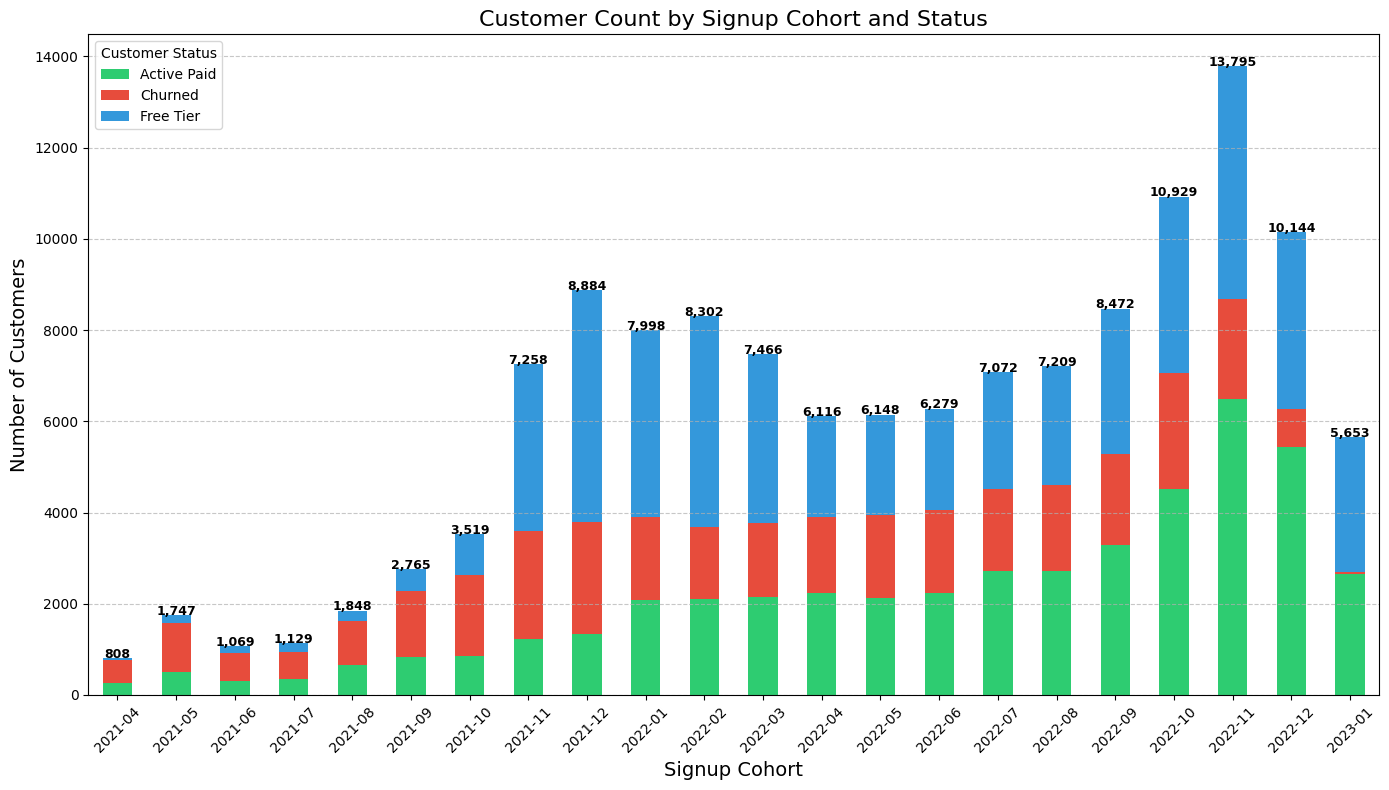

Customer counts by signup cohort and status:
status         Active Paid  Churned  Free Tier
signup_cohort                                 
2021-04                253      504         51
2021-05                502     1075        170
2021-06                313      610        146
2021-07                351      602        176
2021-08                647      978        223
2021-09                833     1443        489
2021-10                850     1782        887
2021-11               1217     2370       3671
2021-12               1336     2453       5095
2022-01               2092     1820       4086
2022-02               2114     1577       4611
2022-03               2157     1605       3704
2022-04               2232     1673       2211
2022-05               2136     1804       2208
2022-06               2233     1827       2219
2022-07               2712     1799       2561
2022-08               2716     1886       2607
2022-09               3283     2010       3179
2022-10        

In [137]:
# Group data by signup cohort and customer status
cohort_status = grouped_df.groupby(['signup_cohort', 'is_active', 'is_canceled', 'converted'])['customer_count'].sum().reset_index()
#cohort_status

# Create new column for customer status
def get_status(row):
    if row['is_active'] == 1 and row['converted'] == 1:
        return 'Active Paid'
    elif row['is_canceled'] == 1:
        return 'Churned'
    else:
        return 'Free Tier'

cohort_status['status'] = cohort_status.apply(get_status, axis=1)

# Pivot table for plotting
cohort_pivot = pd.pivot_table(
    cohort_status, 
    values='customer_count',
    index='signup_cohort',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

# Ensure all status categories exist
for status in ['Active Paid', 'Churned', 'Free Tier']:
    if status not in cohort_pivot.columns:
        cohort_pivot[status] = 0

# Sort by cohort date
cohort_pivot = cohort_pivot.sort_index()

# Create stacked bar chart
plt.figure(figsize=(14, 8))
cohort_pivot.plot(
    kind='bar', 
    stacked=True,
    color=['#2ecc71', '#e74c3c', '#3498db'],  # Green for active, red for churned, blue for free
    ax=plt.gca()
)

# Add total count on top of each bar
for i, cohort in enumerate(cohort_pivot.index):
    total = cohort_pivot.loc[cohort].sum()
    plt.text(i, total + 5, f'{int(total):,}', ha='center', fontsize=9, fontweight='bold')

plt.title('Customer Count by Signup Cohort and Status', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.legend(title='Customer Status')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data table
print("Customer counts by signup cohort and status:")
print(cohort_pivot)

### Above Graph shows us how originations have been trending along with conversion and churn rates. 

- Originations per month generally seen to be increasing. Lets look at percentage to get better idea of retention

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/2305597148.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cohort_retention = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({


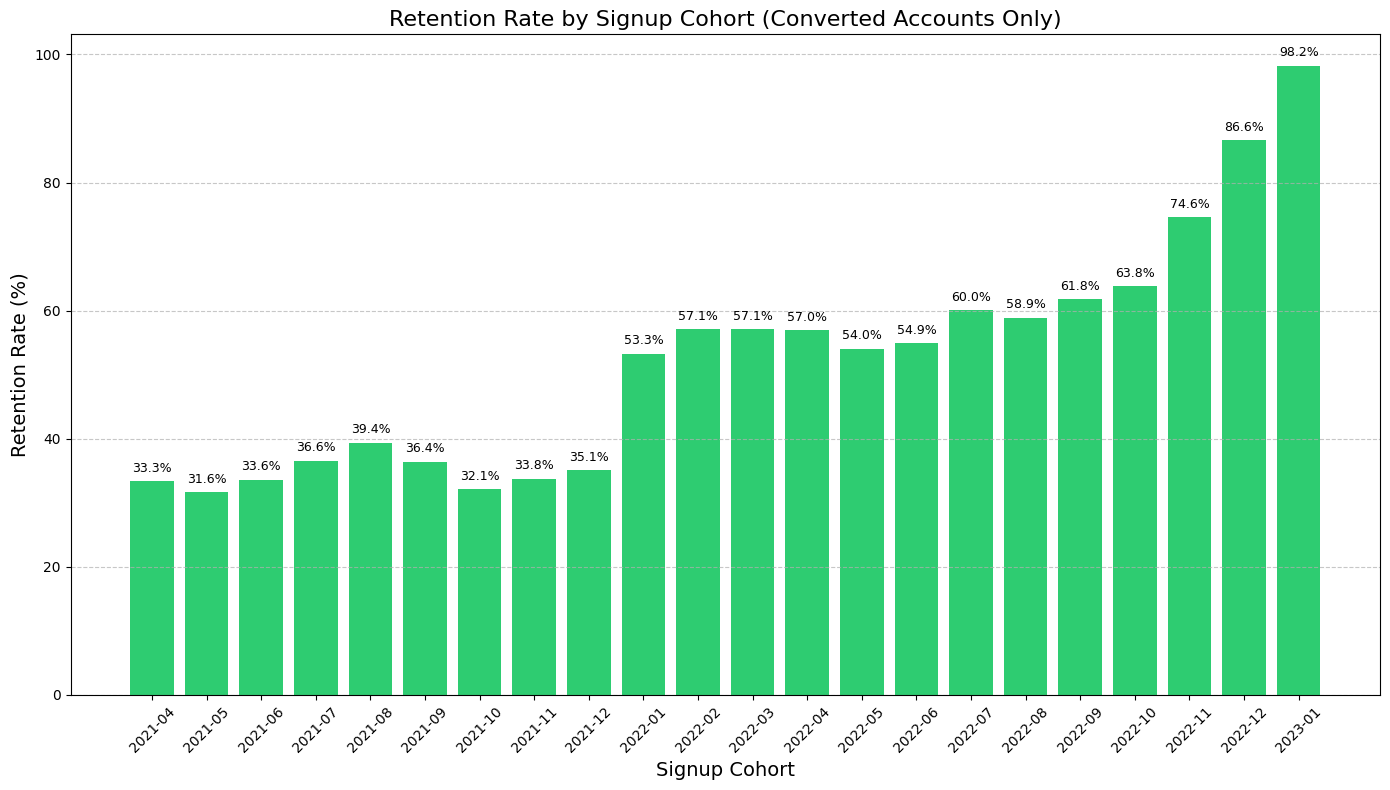

Retention rate by signup cohort (converted accounts only):
   signup_cohort  total_customers  active_customers  retention_rate
0        2021-04            759.0             253.0           33.33
1        2021-05           1587.0             502.0           31.63
2        2021-06            932.0             313.0           33.58
3        2021-07            959.0             351.0           36.60
4        2021-08           1642.0             647.0           39.40
5        2021-09           2287.0             833.0           36.42
6        2021-10           2645.0             850.0           32.14
7        2021-11           3602.0            1217.0           33.79
8        2021-12           3809.0            1336.0           35.07
9        2022-01           3927.0            2092.0           53.27
10       2022-02           3704.0            2114.0           57.07
11       2022-03           3775.0            2157.0           57.14
12       2022-04           3919.0            2232.0      

In [138]:
# Retention rate analysis by signup cohort (for converted accounts only)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1]

# Calculate retention rate for each signup cohort
cohort_retention = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Sort by cohort date
cohort_retention = cohort_retention.sort_values('signup_cohort')

# Create bar chart
plt.figure(figsize=(14, 8))

# Plot retention rate
bars = plt.bar(
    cohort_retention['signup_cohort'],
    cohort_retention['retention_rate'],
    color='#2ecc71'  # Different color from conversion cohort chart
)

# Add data labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 1, 
        f'{height:.1f}%',
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.title('Retention Rate by Signup Cohort (Converted Accounts Only)', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
print("Retention rate by signup cohort (converted accounts only):")
print(cohort_retention[['signup_cohort', 'total_customers', 'active_customers', 'retention_rate']].round(2))

### Above graph shows Retention rates for customers that have converted, some takeaways:
- Retention from 2022-01 and forward seems to be doing very well compared to prior buckets
    - Is this a product change or a pricing change? 
        - ie. did they start offering 1 year subscriptions and we will see retention take in 2022-01 cohort once Jan 2023 passes
        - OR did they improve product or customer mix to improve retention somehow

- Retention falls off in first 3 months then hits a relative steady state of about 55%

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/2282064012.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retention_by_tier = converted_df.groupby(['signup_quarter', 'simple_price_tier']).apply(lambda x: pd.Series({


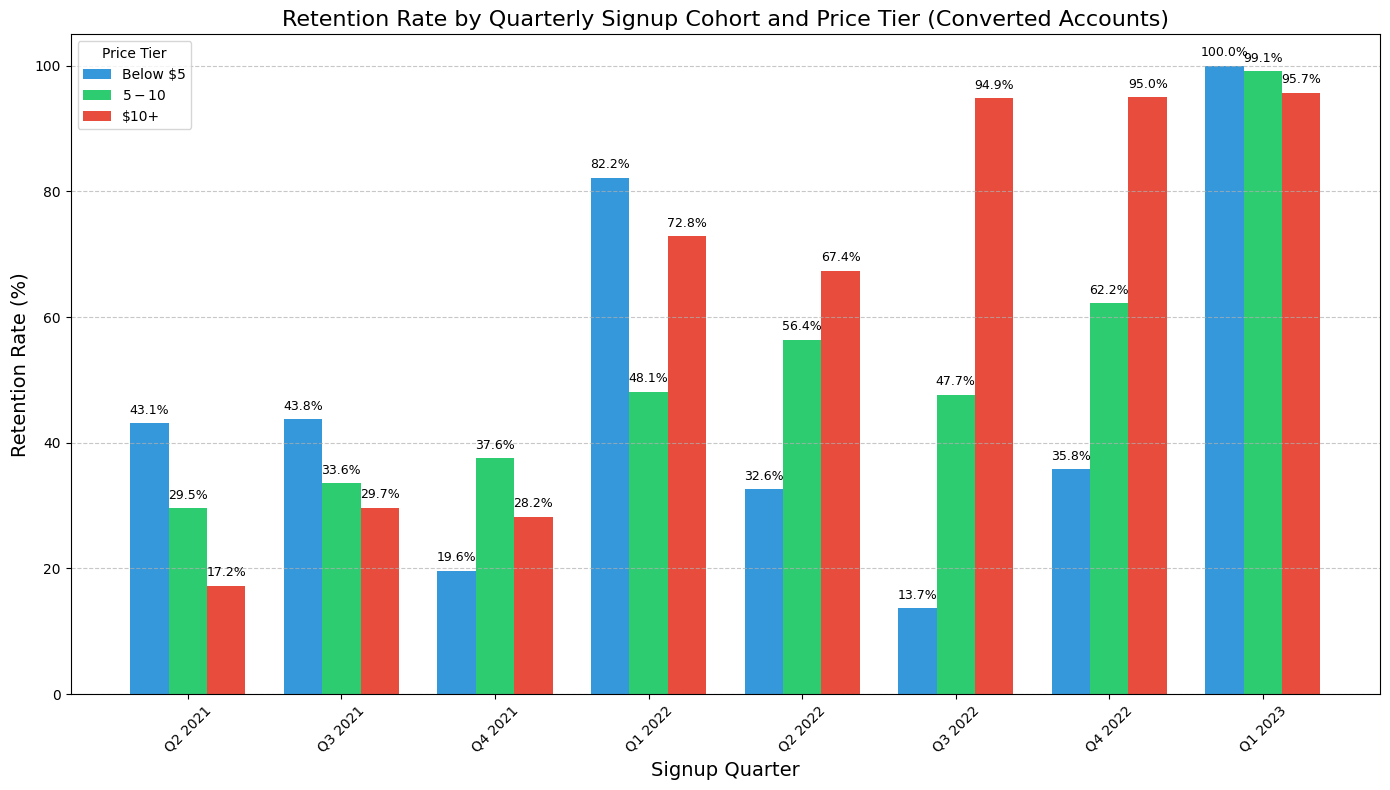

Retention rate (%) by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021            17.2    29.5      43.1
Q3 2021            29.7    33.6      43.8
Q4 2021            28.2    37.6      19.6
Q1 2022            72.8    48.1      82.2
Q2 2022            67.4    56.4      32.6
Q3 2022            94.9    47.7      13.7
Q4 2022            95.0    62.2      35.8
Q1 2023            95.7    99.1     100.0

Sample size (n) by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021             638    1324      1316
Q3 2021             671    2106      2111
Q4 2021             694    7634      1728
Q1 2022             931    8592      1883
Q2 2022             604   10504       831
Q3 2022            4491    9088       861
Q4 2022            9268   11588      1197
Q1 2023             698    1968        33


In [139]:
# Retention rate analysis by quarterly signup cohort and price tier (for converted accounts only)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Calculate retention rate for each quarterly signup cohort and price tier
retention_by_tier = converted_df.groupby(['signup_quarter', 'simple_price_tier']).apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Filter out the 'Unknown' price tier if present
retention_by_tier = retention_by_tier[retention_by_tier['simple_price_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(retention_by_tier['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Price tiers in order
tiers = ['Below $5', '$5-$10', '$10+']

# Create a bar for each price tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = retention_by_tier[retention_by_tier['simple_price_tier'] == tier]
    
    # Prepare data for all quarters (fill missing with zeros)
    retention_rates = []
    for quarter in all_quarters:
        quarter_tier_data = tier_data[tier_data['signup_quarter'] == quarter]
        if len(quarter_tier_data) > 0:
            retention_rates.append(quarter_tier_data['retention_rate'].values[0])
        else:
            retention_rates.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        retention_rates, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Retention Rate by Quarterly Signup Cohort and Price Tier (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.legend(title='Price Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
# Create pivot table for retention rates
retention_pivot = pd.pivot_table(
    retention_by_tier,
    values='retention_rate',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Create pivot table for customer counts
count_pivot = pd.pivot_table(
    retention_by_tier,
    values='total_customers',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Sort both tables by quarter
retention_pivot = retention_pivot.loc[all_quarters]
count_pivot = count_pivot.loc[all_quarters]

# Format the output tables for better readability
print("Retention rate (%) by quarterly cohort and price tier:")
print(retention_pivot.round(1))

print("\nSample size (n) by quarterly cohort and price tier:")
print(count_pivot.astype(int))

### Looks like customers with a higher monthly payment have higher retention 
 *** Remember that total charges includes sign on cost which cannot be traced, appears that more recent months will have higher avg monthly payment as a result

- Still, this tells us that customers that pay more at onset have a higher retention, whether this be from higher MRR or higher onboarding fee


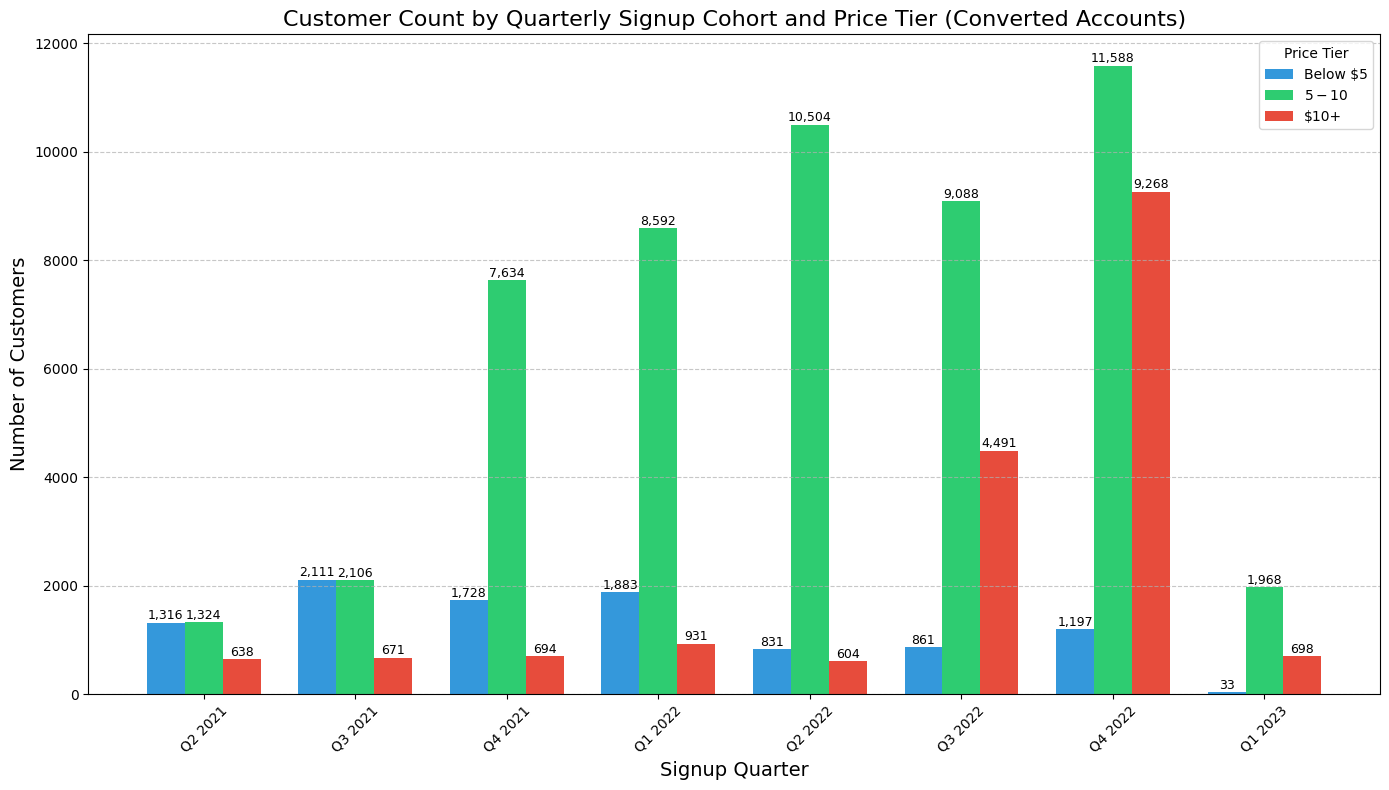

Customer count by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021             638    1324      1316
Q3 2021             671    2106      2111
Q4 2021             694    7634      1728
Q1 2022             931    8592      1883
Q2 2022             604   10504       831
Q3 2022            4491    9088       861
Q4 2022            9268   11588      1197
Q1 2023             698    1968        33

Percentage distribution by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021            19.5    40.4      40.1
Q3 2021            13.7    43.1      43.2
Q4 2021             6.9    75.9      17.2
Q1 2022             8.2    75.3      16.5
Q2 2022             5.1    88.0       7.0
Q3 2022            31.1    62.9       6.0
Q4 2022            42.0    52.5       5.4
Q1 2023            25.9    72.9       1.2


In [140]:
# Analysis of customer counts by quarterly signup cohort and price tier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Aggregate customer counts by quarter and price tier
customer_counts = converted_df.groupby(['signup_quarter', 'simple_price_tier'])['customer_count'].sum().reset_index()

# Filter out the 'Unknown' price tier if present
customer_counts = customer_counts[customer_counts['simple_price_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(customer_counts['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Price tiers in order
tiers = ['Below $5', '$5-$10', '$10+']

# Create a bar for each price tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = customer_counts[customer_counts['simple_price_tier'] == tier]
    
    # Prepare data for all quarters (fill missing with zeros)
    count_values = []
    for quarter in all_quarters:
        quarter_tier_data = tier_data[tier_data['signup_quarter'] == quarter]
        if len(quarter_tier_data) > 0:
            count_values.append(quarter_tier_data['customer_count'].values[0])
        else:
            count_values.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        count_values, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 5,
                f'{int(height):,}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Customer Count by Quarterly Signup Cohort and Price Tier (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.legend(title='Price Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create pivot table for customer counts
count_pivot = pd.pivot_table(
    customer_counts,
    values='customer_count',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Sort table by quarter
count_pivot = count_pivot.loc[all_quarters]

# Display the data
print("Customer count by quarterly cohort and price tier:")
print(count_pivot.astype(int))

# Calculate the percentage distribution
percent_pivot = count_pivot.div(count_pivot.sum(axis=1), axis=0) * 100

print("\nPercentage distribution by quarterly cohort and price tier:")
print(percent_pivot.round(1))

MRR tier thresholds: Low < $5.00 ≤ Medium < $6.69 ≤ High


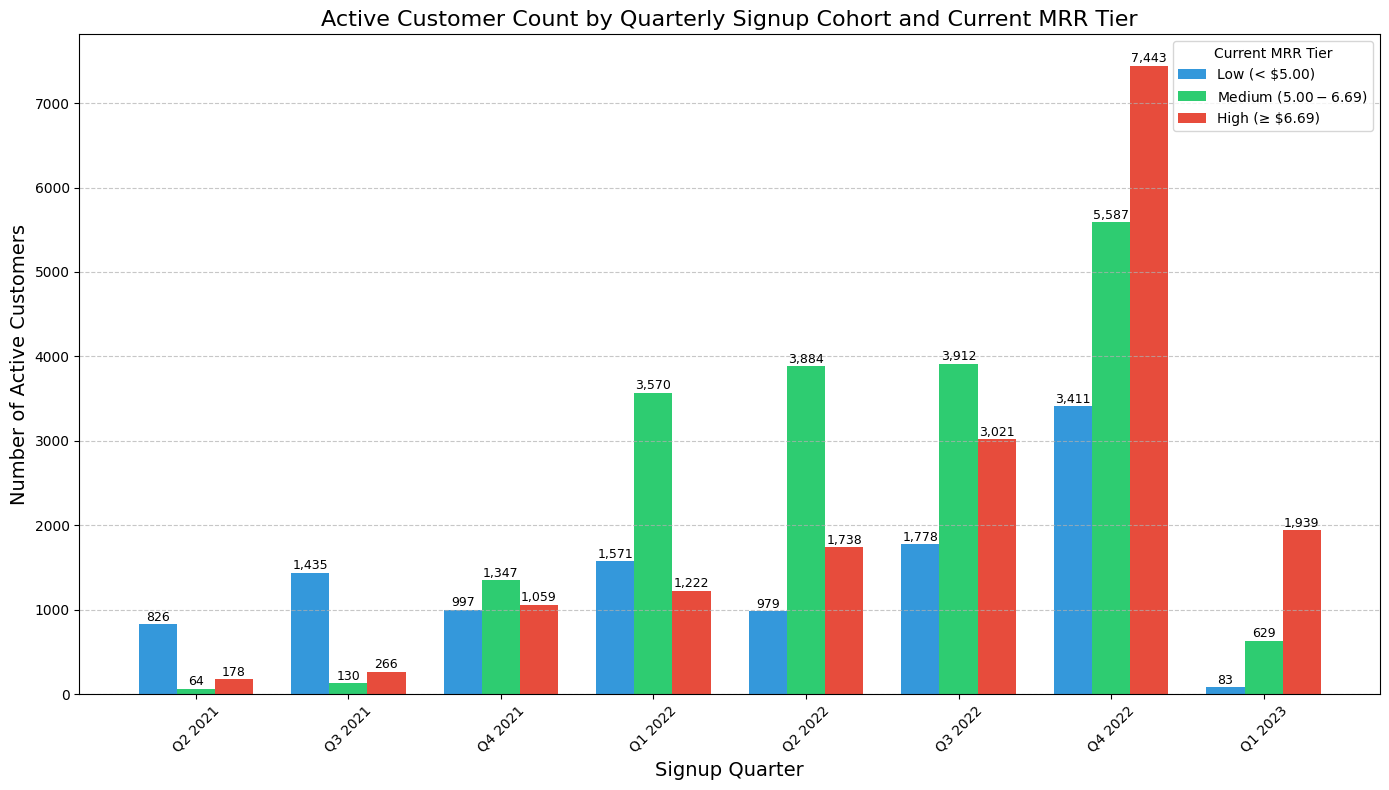

Active customer count by quarterly cohort and MRR tier:
mrr_tier        High (≥ $6.69)  Low (< $5.00)  Medium ($5.00-$6.69)
signup_quarter                                                     
Q2 2021                    178            826                    64
Q3 2021                    266           1435                   130
Q4 2021                   1059            997                  1347
Q1 2022                   1222           1571                  3570
Q2 2022                   1738            979                  3884
Q3 2022                   3021           1778                  3912
Q4 2022                   7443           3411                  5587
Q1 2023                   1939             83                   629

Percentage distribution by quarterly cohort and MRR tier:
mrr_tier        High (≥ $6.69)  Low (< $5.00)  Medium ($5.00-$6.69)
signup_quarter                                                     
Q2 2021                   16.7           77.3                   6.0
Q

In [141]:
# Analysis of customer counts by quarterly signup cohort and current MRR tier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted, active, non-canceled customers
converted_df = grouped_df[(grouped_df['converted'] == 1) & 
                          (grouped_df['is_active'] == 1) & 
                          (grouped_df['is_canceled'] == 0)].copy()

# Create MRR tiers based on current_mrr that are more evenly distributed
# First, let's determine quantile-based thresholds for equal-sized groups

# Get all current_mrr values and calculate quantiles for 3 groups
mrr_values = converted_df['avg_current_mrr'].dropna()
q1 = mrr_values.quantile(1/3)
q2 = mrr_values.quantile(2/3)

print(f"MRR tier thresholds: Low < ${q1:.2f} ≤ Medium < ${q2:.2f} ≤ High")

# Create function to assign MRR tiers
def assign_mrr_tier(mrr):
    if mrr is None or pd.isna(mrr):
        return 'Unknown'
    elif mrr < q1:
        return f'Low (< ${q1:.2f})'
    elif q1 <= mrr < q2:
        return f'Medium (${q1:.2f}-${q2:.2f})'
    else:
        return f'High (≥ ${q2:.2f})'

# Add the MRR tier column
converted_df['mrr_tier'] = converted_df['avg_current_mrr'].apply(assign_mrr_tier)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Aggregate customer counts by quarter and MRR tier
customer_counts = converted_df.groupby(['signup_quarter', 'mrr_tier'])['customer_count'].sum().reset_index()

# Filter out the 'Unknown' MRR tier if present
customer_counts = customer_counts[customer_counts['mrr_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(customer_counts['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each MRR tier
colors = {
    f'Low (< ${q1:.2f})': '#3498db',          # Blue for low MRR
    f'Medium (${q1:.2f}-${q2:.2f})': '#2ecc71',  # Green for medium MRR
    f'High (≥ ${q2:.2f})': '#e74c3c'          # Red for high MRR
}

# MRR tiers in order
tiers = [
    f'Low (< ${q1:.2f})',
    f'Medium (${q1:.2f}-${q2:.2f})',
    f'High (≥ ${q2:.2f})'
]

# Create a bar for each MRR tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = customer_counts[customer_counts['mrr_tier'] == tier]
    
    # Prepare data for all quarters (fill missing with zeros)
    count_values = []
    for quarter in all_quarters:
        quarter_tier_data = tier_data[tier_data['signup_quarter'] == quarter]
        if len(quarter_tier_data) > 0:
            count_values.append(quarter_tier_data['customer_count'].values[0])
        else:
            count_values.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        count_values, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 5,
                f'{int(height):,}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Active Customer Count by Quarterly Signup Cohort and Current MRR Tier', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Number of Active Customers', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.legend(title='Current MRR Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create pivot table for customer counts
count_pivot = pd.pivot_table(
    customer_counts,
    values='customer_count',
    index='signup_quarter',
    columns='mrr_tier'
)

# Sort table by quarter
count_pivot = count_pivot.loc[all_quarters]

# Display the data
print("Active customer count by quarterly cohort and MRR tier:")
print(count_pivot.astype(int))

# Calculate the percentage distribution
percent_pivot = count_pivot.div(count_pivot.sum(axis=1), axis=0) * 100

print("\nPercentage distribution by quarterly cohort and MRR tier:")
print(percent_pivot.round(1))

# Add additional analysis: Calculate average MRR for each tier to verify our groupings
tier_analysis = converted_df.groupby('mrr_tier').agg({
    'avg_current_mrr': ['mean', 'min', 'max', 'count'],
    'customer_count': 'sum'
}).reset_index()

print("\nMRR Tier Analysis:")
print(tier_analysis)

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/944901790.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  provider_mrr = provider_data.groupby('signup_month').apply(
/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/944901790.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  provider_mrr = provider_data.groupby('signup_month').apply(
/var/folders/7k/wrk7c3wx3pl7px430tg5

<Figure size 1600x800 with 0 Axes>

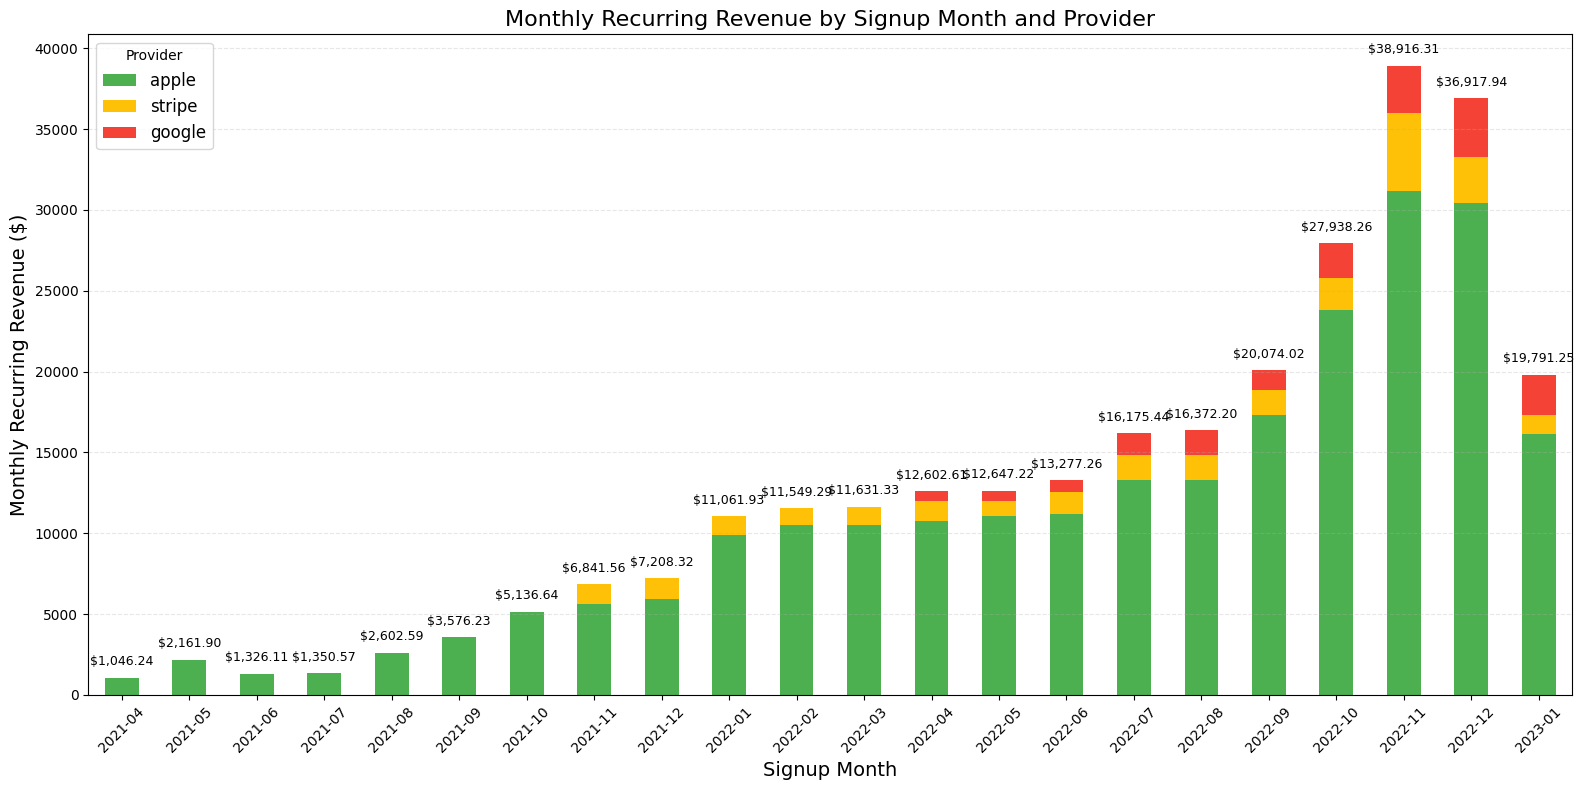

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Create empty DataFrame to store provider data by month
provider_mrr_by_month = pd.DataFrame(index=all_months)

# Calculate MRR by signup month for each provider
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    
    # Calculate total MRR by signup month for this provider
    provider_mrr = provider_data.groupby('signup_month').apply(
        lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
    )
    provider_mrr_by_month[provider] = provider_mrr

# Fill NaN values with 0
provider_mrr_by_month = provider_mrr_by_month.fillna(0)

# Create a stacked bar chart for provider MRR by month
plt.figure(figsize=(16, 8))
ax = provider_mrr_by_month.plot(
    kind='bar', stacked=True, figsize=(16, 8),
    color=['#4CAF50', '#FFC107', '#F44336'])  # Colors for each provider

# Add total line
provider_mrr_by_month['Total'] = provider_mrr_by_month.sum(axis=1)
# plt.plot(range(len(provider_mrr_by_month)), provider_mrr_by_month['Total'], 
#          marker='o', color='black', linewidth=2, label='Total MRR')

plt.title('Monthly Recurring Revenue by Signup Month and Provider', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Monthly Recurring Revenue ($)', fontsize=14)
plt.legend(title='Provider', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add total value labels
for i, mrr in enumerate(provider_mrr_by_month['Total']):
    if mrr > 0:
        plt.text(i, mrr + provider_mrr_by_month['Total'].max()*0.02,
                f'${mrr:,.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


Monthly Recurring Revenue by Provider and Signup Month:
            apple   stripe   google     Total
2021-04   1046.24     0.00     0.00   1046.24
2021-05   2161.90     0.00     0.00   2161.90
2021-06   1326.11     0.00     0.00   1326.11
2021-07   1350.57     0.00     0.00   1350.57
2021-08   2602.59     0.00     0.00   2602.59
2021-09   3576.23     0.00     0.00   3576.23
2021-10   5136.64     0.00     0.00   5136.64
2021-11   5634.38  1207.18     0.00   6841.56
2021-12   5913.21  1295.11     0.00   7208.32
2022-01   9889.75  1172.18     0.00  11061.93
2022-02  10485.76  1063.53     0.00  11549.29
2022-03  10485.85  1125.73    19.75  11631.33
2022-04  10791.57  1196.38   614.66  12602.61
2022-05  11059.74   948.27   639.21  12647.22
2022-06  11198.68  1336.81   741.77  13277.26
2022-07  13287.67  1561.13  1326.64  16175.44
2022-08  13267.67  1600.69  1503.84  16372.20
2022-09  17291.34  1586.74  1195.94  20074.02
2022-10  23792.88  2017.25  2128.13  27938.26
2022-11  31172.47  4821.

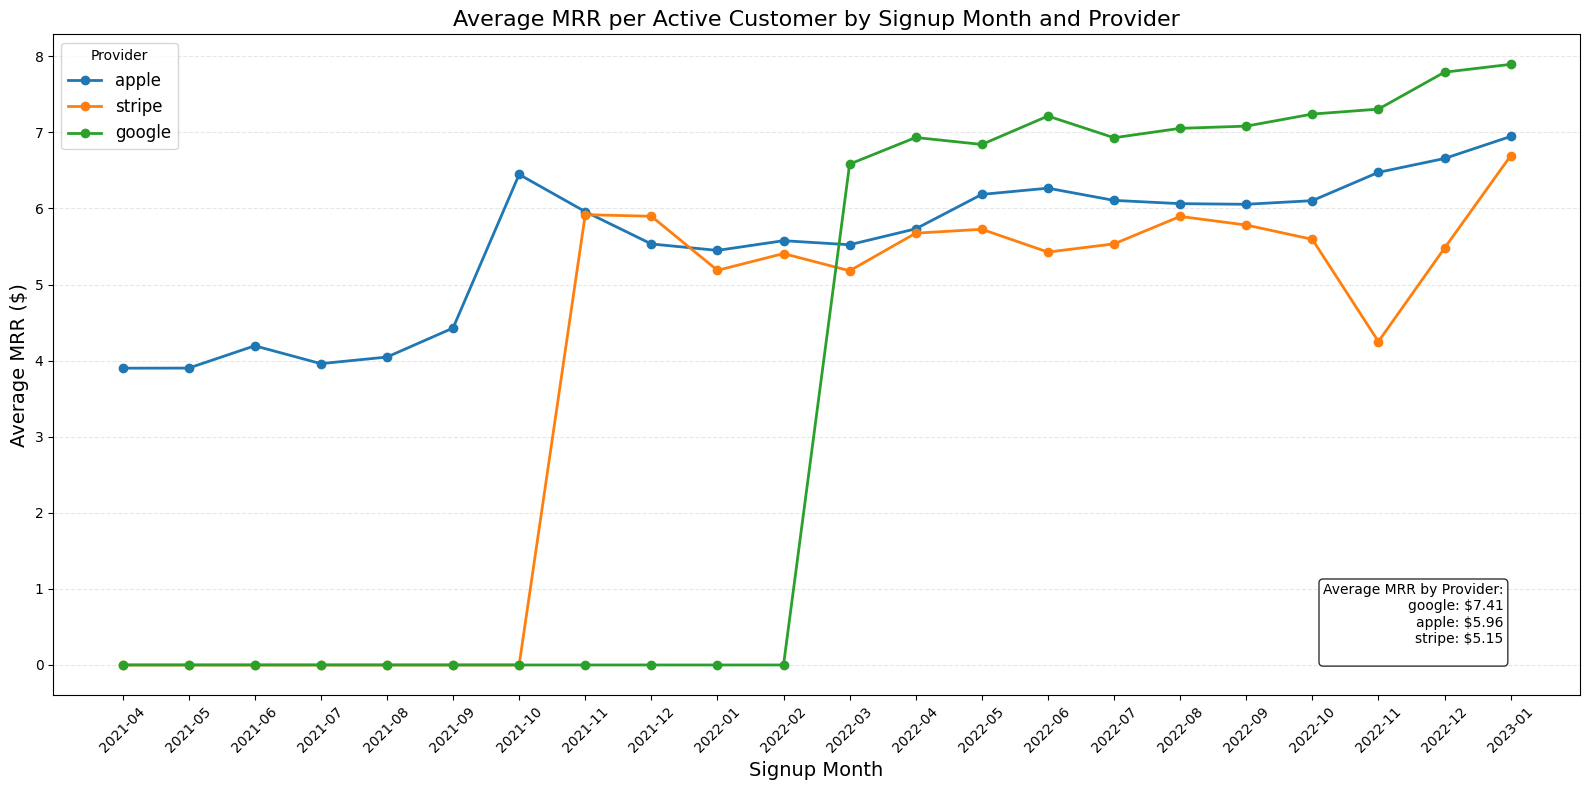

In [143]:

# Print out the data for reference
print("Monthly Recurring Revenue by Provider and Signup Month:")
print(provider_mrr_by_month.round(2))

# Also create a chart for average MRR per customer by provider
plt.figure(figsize=(16, 8))

# Create empty DataFrame for average MRR per customer
avg_mrr_by_provider_month = pd.DataFrame(index=all_months)

# Calculate average MRR per customer by signup month for each provider
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    
    # Calculate average MRR by signup month
    active_provider_data = provider_data[provider_data['is_active'] == 1]
    monthly_avg_mrr = active_provider_data.groupby('signup_month')['avg_current_mrr'].mean()
    avg_mrr_by_provider_month[provider] = monthly_avg_mrr

# Fill NaN values with 0
avg_mrr_by_provider_month = avg_mrr_by_provider_month.fillna(0)

# Create line chart for average MRR by provider over time
for provider in df_analysis['provider'].unique():
    plt.plot(range(len(avg_mrr_by_provider_month)),
             avg_mrr_by_provider_month[provider],
             marker='o', linewidth=2, label=provider)

plt.title('Average MRR per Active Customer by Signup Month and Provider', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Average MRR ($)', fontsize=14)
plt.legend(title='Provider', fontsize=12)
plt.xticks(range(len(avg_mrr_by_provider_month)), avg_mrr_by_provider_month.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Calculate average MRR by provider across all months
avg_mrr_by_provider = {}
for provider in df_analysis['provider'].unique():
    # Get active customers for this provider
    active_provider_data = df_analysis[(df_analysis['provider'] == provider) & 
                                     (df_analysis['is_active'] == 1)]
    
    # Calculate weighted average MRR across all months
    if len(active_provider_data) > 0:
        total_mrr = (active_provider_data['avg_current_mrr'] * 
                    active_provider_data['customer_count']).sum()
        total_customers = active_provider_data['customer_count'].sum()
        avg_mrr = total_mrr / total_customers if total_customers > 0 else 0
    else:
        avg_mrr = 0
    
    avg_mrr_by_provider[provider] = avg_mrr

# Add a text box with average MRR by provider
textstr = 'Average MRR by Provider:\n'
for provider, avg_mrr in sorted(avg_mrr_by_provider.items(), key=lambda x: x[1], reverse=True):
    textstr += f"{provider}: ${avg_mrr:.2f}\n"

# Create a box with rounded corners and a light background
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# Add the text box to the chart in the bottom right corner
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/2423450093.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_overall = df_analysis.groupby('signup_month').apply(


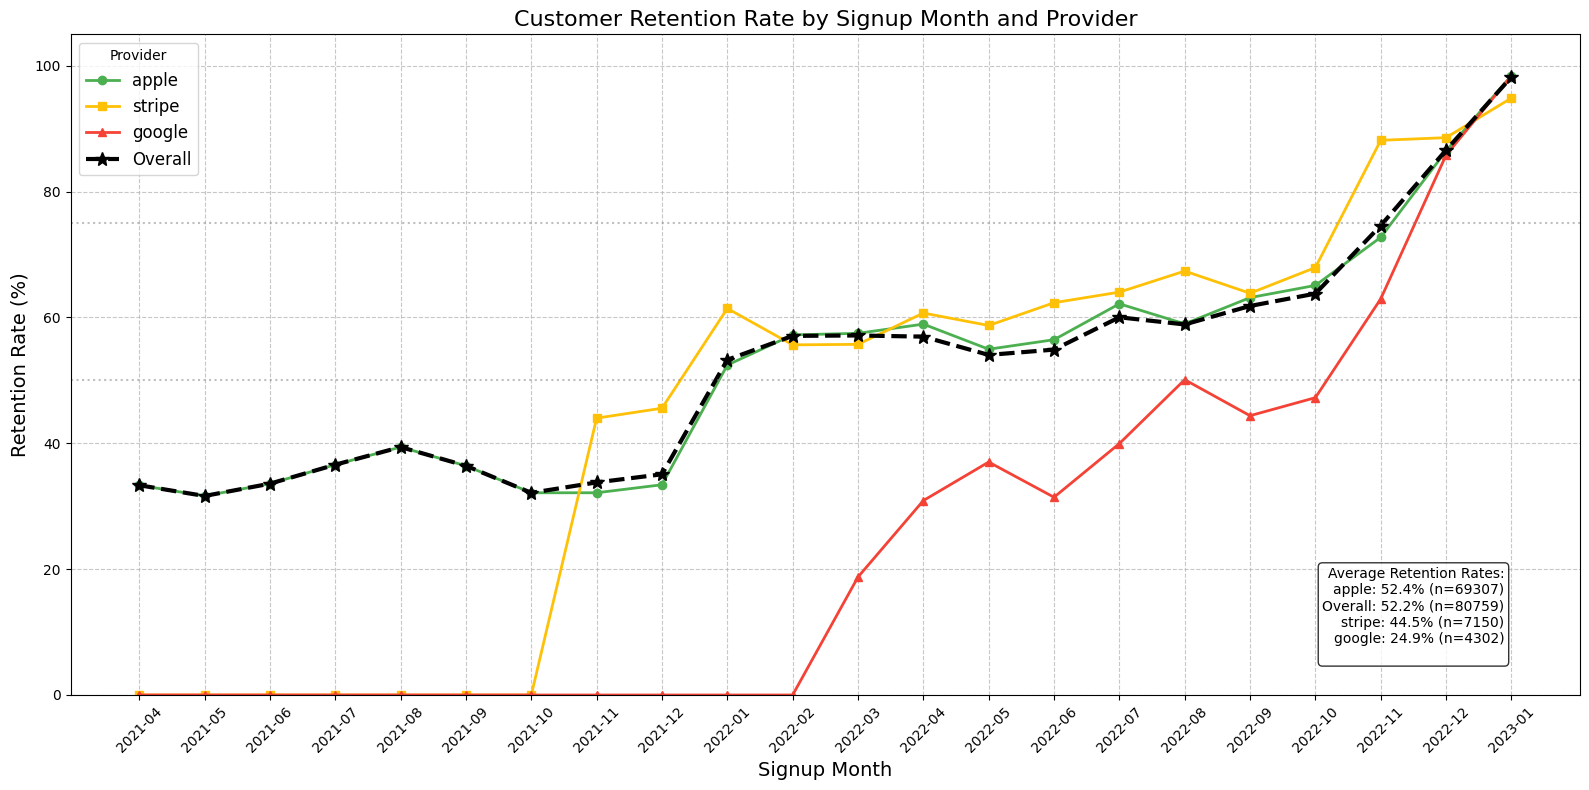

Average Retention Rate by Provider:
apple: 57.6% (n=69307)
stripe: 67.7% (n=7150)
google: 54.1% (n=4302)

Overall Retention: 58.3%


In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Create empty DataFrame to store retention rates by provider and month
retention_by_provider = pd.DataFrame(index=all_months)

# Calculate retention rates for each provider across signup months
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    
    # Calculate retention for each signup month
    provider_retention = []
    
    for month in all_months:
        # Get customers who signed up in this month with this provider
        month_cohort = provider_data[provider_data['signup_month'] == month]
        
        # Calculate total customers and active customers
        total_customers = month_cohort['customer_count'].sum()
        active_customers = month_cohort[month_cohort['is_active'] == 1]['customer_count'].sum()
        
        # Calculate retention rate (avoid division by zero)
        retention_rate = (active_customers / total_customers * 100) if total_customers > 0 else 0
        provider_retention.append(retention_rate)
    
    # Add to DataFrame
    retention_by_provider[provider] = provider_retention

# Fill NaN values with 0
retention_by_provider = retention_by_provider.fillna(0)

# Calculate overall retention rate across all providers
df_overall = df_analysis.groupby('signup_month').apply(
    lambda x: (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum() * 100) 
    if x['customer_count'].sum() > 0 else 0
)

retention_by_provider['Overall'] = df_overall.values

# Create a line chart for retention rates by provider
plt.figure(figsize=(16, 8))

# Use distinct colors and markers for each provider
colors = ['#4CAF50', '#FFC107', '#F44336', '#000000']  # Green, Yellow, Red, Black (for Overall)
markers = ['o', 's', '^', '*']  # Circle, Square, Triangle, Star

# Plot retention lines for each provider
for i, provider in enumerate(retention_by_provider.columns):
    color_idx = min(i, len(colors)-1)
    marker_idx = min(i, len(markers)-1)
    
    if provider == 'Overall':
        # Make the overall line stand out
        plt.plot(range(len(all_months)), retention_by_provider[provider], 
                 color=colors[color_idx], marker=markers[marker_idx], 
                 linewidth=3, linestyle='--', label=provider, markersize=10)
    else:
        plt.plot(range(len(all_months)), retention_by_provider[provider], 
                 color=colors[color_idx], marker=markers[marker_idx], 
                 linewidth=2, label=provider)

# Add reference lines at common retention thresholds
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=75, color='gray', linestyle=':', alpha=0.5)

plt.title('Customer Retention Rate by Signup Month and Provider', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.legend(title='Provider', fontsize=12)
plt.xticks(range(len(all_months)), all_months, rotation=45)
plt.ylim(0, 105)  # Set y-axis limit to accommodate labels
plt.grid(True, linestyle='--', alpha=0.7)

# Calculate average retention rates and total customers by provider for the text box
avg_stats = {}
for provider in retention_by_provider.columns:
    avg_retention = retention_by_provider[provider].mean()
    
    # Also get the total customer count for context
    if provider != 'Overall':
        provider_data = df_analysis[df_analysis['provider'] == provider]
        total_customers = provider_data['customer_count'].sum()
    else:
        total_customers = df_analysis['customer_count'].sum()
    
    avg_stats[provider] = {
        'retention': avg_retention,
        'customers': total_customers
    }

# Create a text box with average retention rates
textstr = 'Average Retention Rates:\n'
for provider, stats in sorted(avg_stats.items(), key=lambda x: x[1]['retention'], reverse=True):
    textstr += f"{provider}: {stats['retention']:.1f}% (n={int(stats['customers'])})\n"

# Add a text box for average retention rates
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print retention statistics by provider
print("Average Retention Rate by Provider:")
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    total = provider_data['customer_count'].sum()
    active = provider_data[provider_data['is_active'] == 1]['customer_count'].sum()
    retention = (active / total * 100) if total > 0 else 0
    print(f"{provider}: {retention:.1f}% (n={int(total)})")

print(f"\nOverall Retention: {(df_analysis[df_analysis['is_active'] == 1]['customer_count'].sum() / df_analysis['customer_count'].sum() * 100):.1f}%")

Top 3 countries by MRR: ['United States of America', 'United Kingdom of Great Britain and Northern Ireland', 'Germany']


/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/3702102795.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_mrr = df_analysis.groupby('personal_person_geo_country').apply(
/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/3702102795.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_mrr = country_data.groupby('signup_month').apply(
/var/folders/7k/wrk7c3wx

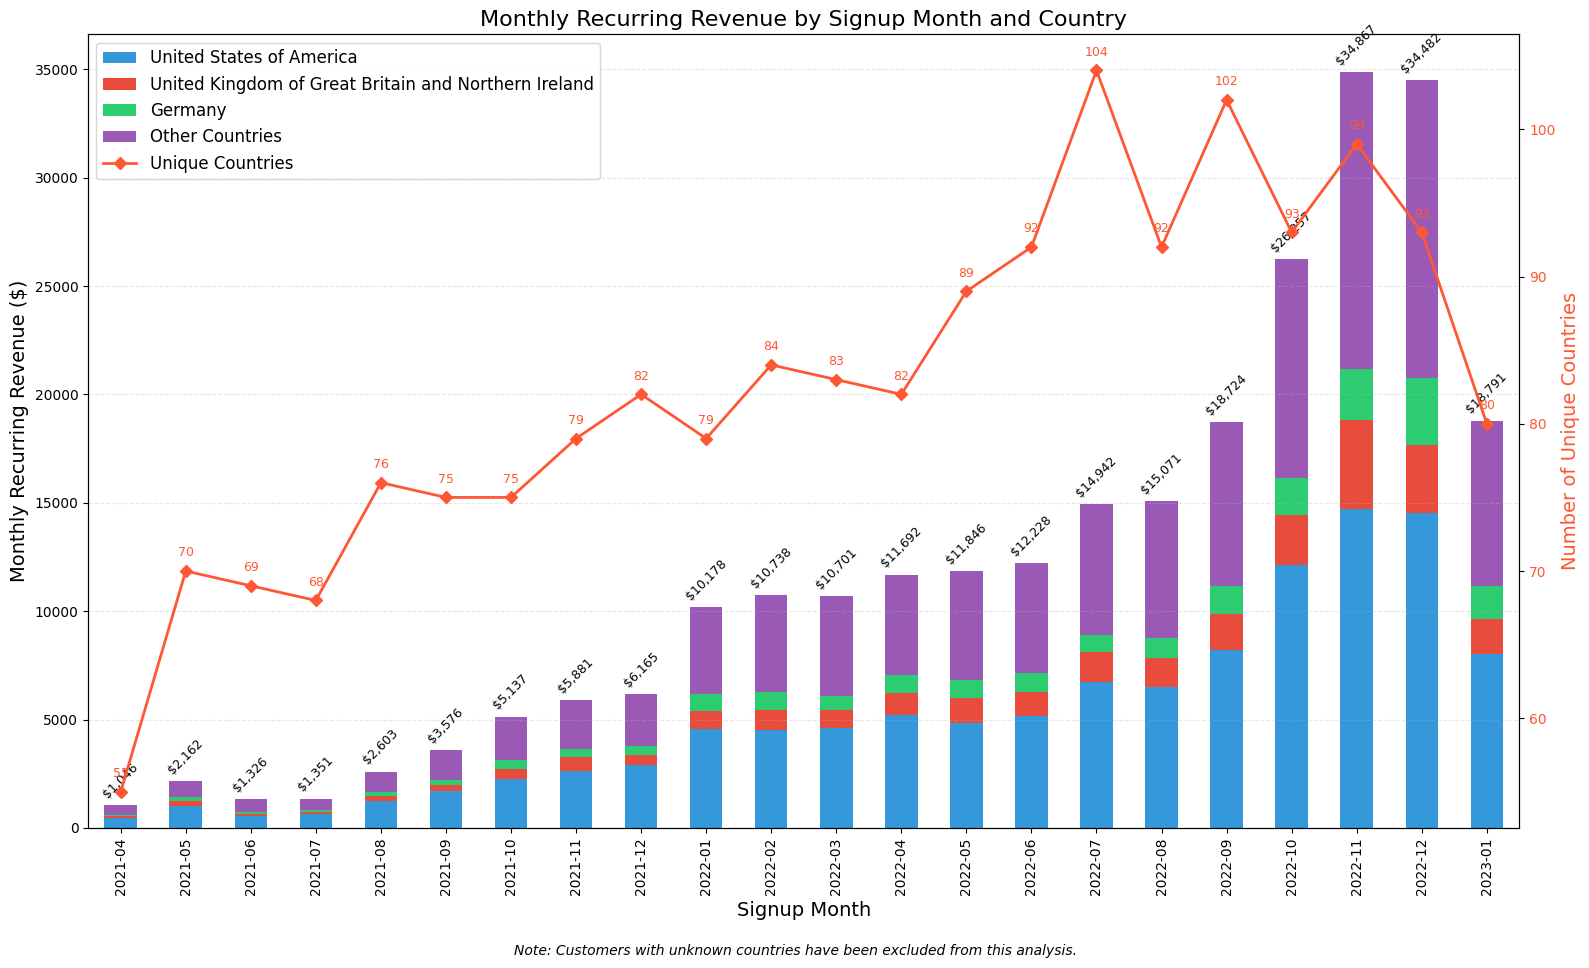

Monthly Recurring Revenue by Country and Signup Month:
         United States of America  \
2021-04                    482.43   
2021-05                    999.16   
2021-06                    535.10   
2021-07                    628.05   
2021-08                   1235.74   
2021-09                   1699.91   
2021-10                   2249.78   
2021-11                   2650.75   
2021-12                   2905.49   
2022-01                   4550.49   
2022-02                   4541.36   
2022-03                   4627.21   
2022-04                   5211.90   
2022-05                   4856.43   
2022-06                   5151.61   
2022-07                   6724.97   
2022-08                   6518.30   
2022-09                   8231.16   
2022-10                  12130.81   
2022-11                  14700.42   
2022-12                  14539.90   
2023-01                   8011.13   

         United Kingdom of Great Britain and Northern Ireland  Germany  \
2021-04            

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Filter out entries with unknown countries
df_analysis = df_analysis[df_analysis['personal_person_geo_country'].notna() & 
                         (df_analysis['personal_person_geo_country'] != 'Unknown')]

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Identify top 3 countries by total MRR
country_mrr = df_analysis.groupby('personal_person_geo_country').apply(
    lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
).sort_values(ascending=False)

top_3_countries = country_mrr.head(3).index.tolist()
print(f"Top 3 countries by MRR: {top_3_countries}")

# Create empty DataFrame to store country data by month
country_mrr_by_month = pd.DataFrame(index=all_months)

# Calculate MRR by signup month for each top country
for country in top_3_countries:
    country_data = df_analysis[df_analysis['personal_person_geo_country'] == country]
    
    # Calculate total MRR by signup month for this country
    country_mrr = country_data.groupby('signup_month').apply(
        lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
    )
    country_mrr_by_month[country] = country_mrr

# Calculate "Other Countries" MRR
other_countries_data = df_analysis[~df_analysis['personal_person_geo_country'].isin(top_3_countries)]
other_countries_mrr = other_countries_data.groupby('signup_month').apply(
    lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
)
country_mrr_by_month['Other Countries'] = other_countries_mrr

# Calculate unique countries count by month
unique_countries_by_month = []
for month in all_months:
    month_data = df_analysis[df_analysis['signup_month'] == month]
    unique_count = month_data['personal_person_geo_country'].nunique()
    unique_countries_by_month.append(unique_count)

# Fill NaN values with 0
country_mrr_by_month = country_mrr_by_month.fillna(0)

# Create a stacked bar chart for country MRR by month with an additional axis for country count
plt.figure(figsize=(16, 10))  # Increase height for better spacing

# Define colors for better contrast
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']  # Blue, Red, Green, Purple

# Primary axis for the stacked bar chart
ax1 = plt.subplot(111)
country_mrr_by_month[top_3_countries + ['Other Countries']].plot(
    kind='bar', stacked=True, figsize=(16, 10),
    color=colors[:4], ax=ax1)  # Use defined colors

# Add total line
country_mrr_by_month['Total'] = country_mrr_by_month.sum(axis=1)
# ax1.plot(range(len(country_mrr_by_month)), country_mrr_by_month['Total'], 
#          marker='o', color='black', linewidth=2, label='Total MRR')

# Set up the primary y-axis
ax1.set_ylabel('Monthly Recurring Revenue ($)', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_title('Monthly Recurring Revenue by Signup Month and Country', fontsize=16)
ax1.set_xlabel('Signup Month', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Create a secondary axis for unique country count
ax2 = ax1.twinx()
ax2.plot(range(len(all_months)), unique_countries_by_month, 
         marker='D', color='#FF5733', linewidth=2, 
         label='Unique Countries')
ax2.set_ylabel('Number of Unique Countries', fontsize=14, color='#FF5733')
ax2.tick_params(axis='y', labelcolor='#FF5733')

# Add total value labels with diagonal orientation and better positioning
for i, mrr in enumerate(country_mrr_by_month['Total']):
    if mrr > 0:
        ax1.text(i, mrr + country_mrr_by_month['Total'].max()*0.01, 
                f'${mrr:,.0f}',  # Simplified to whole numbers
                ha='center', fontsize=9,
                rotation=45)  # Diagonal text

# Add country count labels
for i, count in enumerate(unique_countries_by_month):
    if count > 0:
        ax2.text(i, count + 1, 
                f'{count}', 
                ha='center', color='#FF5733', fontsize=9)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

# Add note about unknown countries being filtered out
plt.figtext(0.5, 0.01, 'Note: Customers with unknown countries have been excluded from this analysis.',
           ha='center', fontsize=10, style='italic')

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the note
plt.show()

# Print out the data for reference
print("Monthly Recurring Revenue by Country and Signup Month:")
print(country_mrr_by_month.drop('Total', axis=1).round(2))

print("\nUnique countries by signup month:")
country_data = pd.DataFrame({
    'signup_month': all_months,
    'unique_countries': unique_countries_by_month
})
print(country_data)

Top 5 countries by retention rate: ['United States of America', 'Japan', 'Ireland', 'United Kingdom of Great Britain and Northern Ireland', 'Israel']


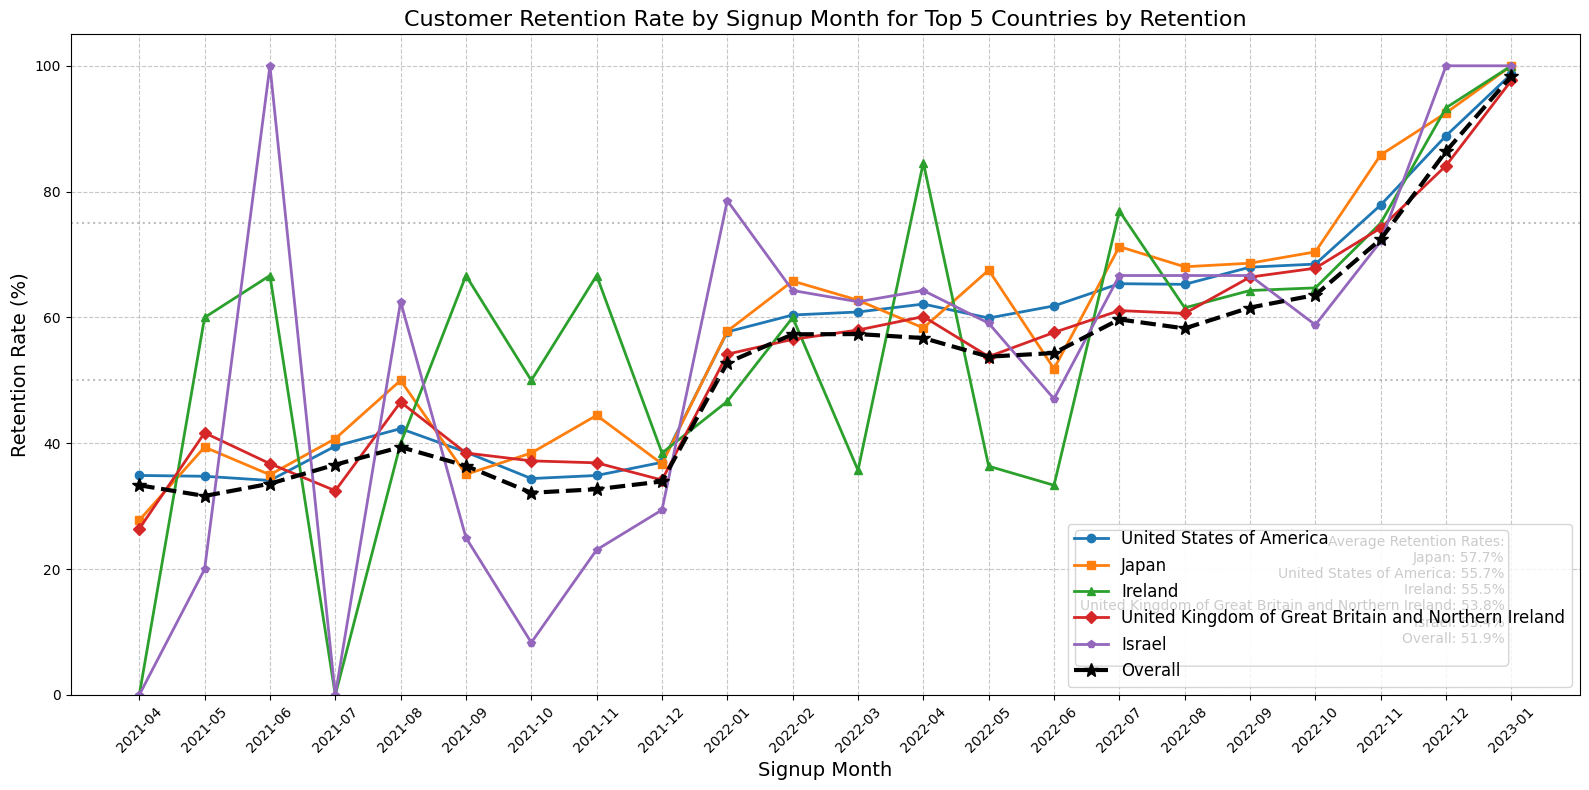


Detailed stats for top 5 countries by retention rate:
United States of America: 62.0% retention, 31036 customers, $3.09 avg MRR
Japan: 61.6% retention, 1673 customers, $2.70 avg MRR
Ireland: 61.3% retention, 225 customers, $3.73 avg MRR
United Kingdom of Great Britain and Northern Ireland: 60.5% retention, 6331 customers, $3.40 avg MRR
Israel: 59.8% retention, 333 customers, $3.36 avg MRR


In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Filter out entries with unknown countries
df_analysis = df_analysis[df_analysis['personal_person_geo_country'].notna() & 
                         (df_analysis['personal_person_geo_country'] != 'Unknown')]

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Calculate overall retention for each country
country_retention = {}
for country in df_analysis['personal_person_geo_country'].unique():
    country_data = df_analysis[df_analysis['personal_person_geo_country'] == country]
    
    # Only include countries with a meaningful sample size (at least 100 customers)
    total_customers = country_data['customer_count'].sum()
    if total_customers >= 100:
        active_customers = country_data[country_data['is_active'] == 1]['customer_count'].sum()
        retention_rate = (active_customers / total_customers * 100)
        country_retention[country] = retention_rate

# Get top 5 countries by retention rate
top_5_countries = sorted(country_retention.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_country_names = [country for country, _ in top_5_countries]
print(f"Top 5 countries by retention rate: {top_5_country_names}")

# Create empty DataFrame to store retention rates by country and month
retention_by_country = pd.DataFrame(index=all_months)

# Calculate retention rates for top 5 countries across signup months
for country in top_5_country_names:
    country_data = df_analysis[df_analysis['personal_person_geo_country'] == country]
    
    # Calculate retention for each signup month
    country_retention = []
    
    for month in all_months:
        # Get customers who signed up in this month from this country
        month_cohort = country_data[country_data['signup_month'] == month]
        
        # Calculate total customers and active customers
        total_customers = month_cohort['customer_count'].sum()
        active_customers = month_cohort[month_cohort['is_active'] == 1]['customer_count'].sum()
        
        # Calculate retention rate (avoid division by zero)
        retention_rate = (active_customers / total_customers * 100) if total_customers > 0 else 0
        country_retention.append(retention_rate)
    
    # Add to DataFrame
    retention_by_country[country] = country_retention

# Calculate overall retention rate across all countries
overall_retention = []
for month in all_months:
    month_data = df_analysis[df_analysis['signup_month'] == month]
    total = month_data['customer_count'].sum()
    active = month_data[month_data['is_active'] == 1]['customer_count'].sum()
    retention = (active / total * 100) if total > 0 else 0
    overall_retention.append(retention)

retention_by_country['Overall'] = overall_retention

# Fill NaN values with 0
retention_by_country = retention_by_country.fillna(0)

# Create a line chart for retention rates by country
plt.figure(figsize=(16, 8))

# Define colors for better contrast
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#000000']  # Last color is for Overall
markers = ['o', 's', '^', 'D', 'p', '*']  # Different marker for each line

# Plot retention lines for each country
for i, country in enumerate(retention_by_country.columns):
    if country == 'Overall':
        plt.plot(range(len(all_months)), retention_by_country[country], 
                 color=colors[-1], marker=markers[-1], 
                 linewidth=3, linestyle='--', label=country, markersize=10)
    else:
        plt.plot(range(len(all_months)), retention_by_country[country], 
                 color=colors[i], marker=markers[i], 
                 linewidth=2, label=country)

# Add reference lines at common retention thresholds
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=75, color='gray', linestyle=':', alpha=0.5)

plt.title('Customer Retention Rate by Signup Month for Top 5 Countries by Retention', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(range(len(all_months)), all_months, rotation=45)
plt.ylim(0, 105)  # Set y-axis limit to accommodate labels
plt.grid(True, linestyle='--', alpha=0.7)

# Calculate average retention rates for text box
avg_stats = {}
for country in retention_by_country.columns:
    avg_retention = retention_by_country[country].mean()
    avg_stats[country] = avg_retention

# Create a text box with average retention rates
textstr = 'Average Retention Rates:\n'
# Sort by highest retention
for country, avg in sorted(avg_stats.items(), key=lambda x: x[1], reverse=True):
    textstr += f"{country}: {avg:.1f}%\n"

# Add a text box for average retention rates
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print out more detailed stats about these top 5 countries
print("\nDetailed stats for top 5 countries by retention rate:")
for country in top_5_country_names:
    country_data = df_analysis[df_analysis['personal_person_geo_country'] == country]
    total = country_data['customer_count'].sum()
    active = country_data[country_data['is_active'] == 1]['customer_count'].sum()
    retention = (active / total * 100)
    avg_mrr = country_data['avg_current_mrr'].mean()
    print(f"{country}: {retention:.1f}% retention, {total:.0f} customers, ${avg_mrr:.2f} avg MRR")

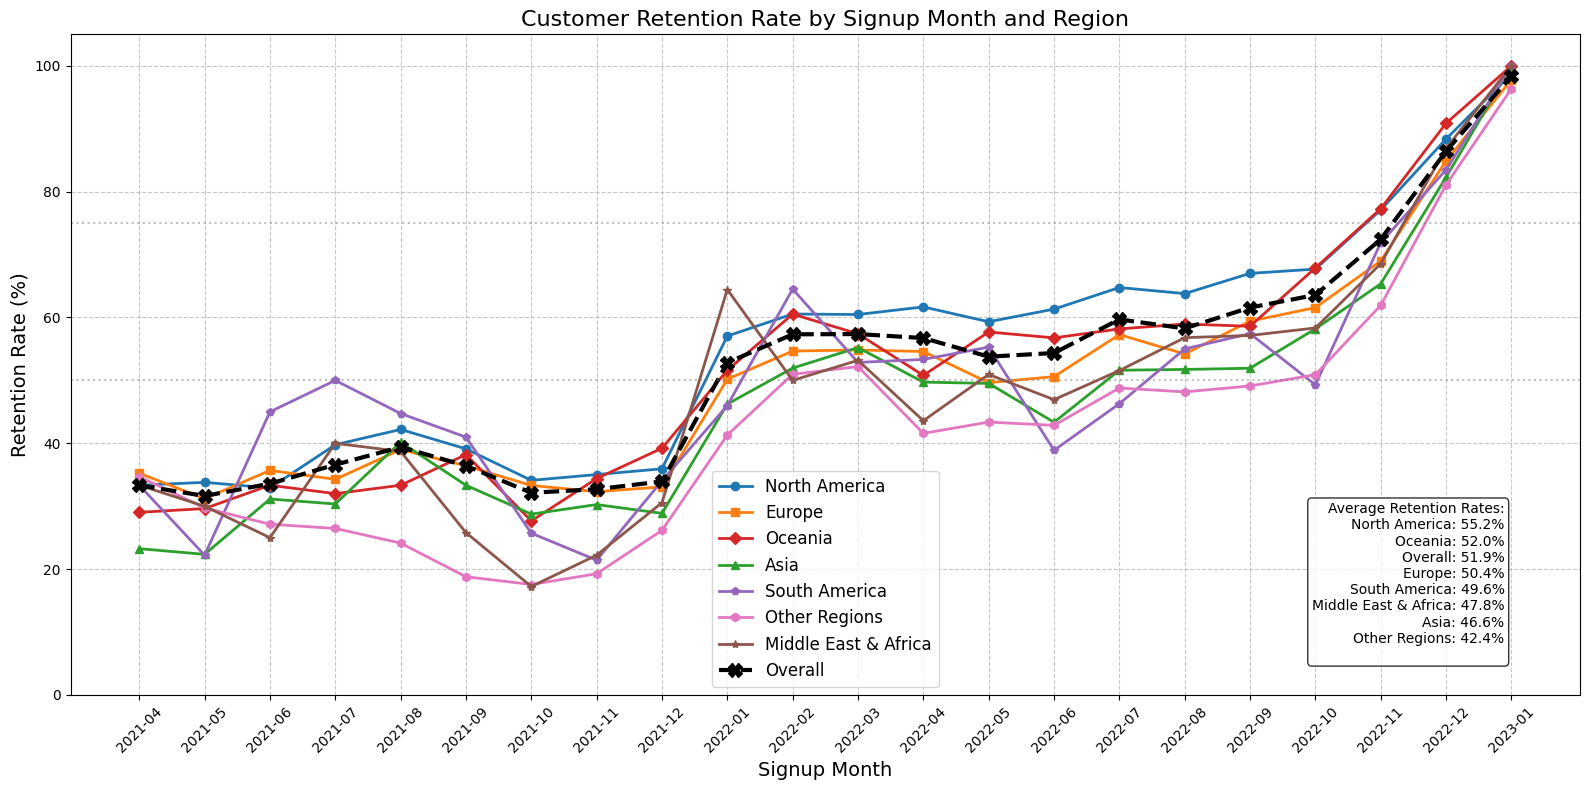


Detailed stats for retention rates by region:
North America: 61.5% retention, 34672 customers, $3.18 avg MRR
Oceania: 58.4% retention, 2672 customers, $3.57 avg MRR
Europe: 55.6% retention, 26266 customers, $3.41 avg MRR
Middle East & Africa: 54.1% retention, 1008 customers, $3.16 avg MRR
South America: 53.9% retention, 1612 customers, $3.20 avg MRR
Asia: 50.8% retention, 4094 customers, $2.87 avg MRR
Other Regions: 47.3% retention, 4577 customers, $3.12 avg MRR


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Filter out entries with unknown countries
df_analysis = df_analysis[df_analysis['personal_person_geo_country'].notna() & 
                         (df_analysis['personal_person_geo_country'] != 'Unknown')]

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Define region/continent mapping for countries
region_mapping = {
    'North America': ['United States of America', 'Canada', 'Mexico'],
    'Europe': [
        'United Kingdom of Great Britain and Northern Ireland', 'Germany', 'France', 
        'Italy', 'Spain', 'Netherlands', 'Switzerland', 'Sweden', 'Belgium', 
        'Denmark', 'Norway', 'Finland', 'Ireland', 'Austria', 'Poland', 'Portugal', 
        'Greece', 'Czech Republic', 'Hungary', 'Romania', 'Ukraine'
    ],
    'Asia': [
        'Japan', 'China', 'South Korea', 'India', 'Singapore', 'Hong Kong', 
        'Taiwan', 'Malaysia', 'Thailand', 'Indonesia', 'Philippines', 'Vietnam'
    ],
    'Oceania': ['Australia', 'New Zealand'],
    'South America': [
        'Brazil', 'Argentina', 'Colombia', 'Chile', 'Peru', 'Venezuela', 
        'Ecuador', 'Uruguay', 'Paraguay', 'Bolivia'
    ],
    'Middle East & Africa': [
        'South Africa', 'United Arab Emirates', 'Israel', 'Egypt', 'Turkey', 
        'Saudi Arabia', 'Kenya', 'Nigeria', 'Morocco'
    ]
}

# Add region column to the dataframe
def assign_region(country):
    for region, countries in region_mapping.items():
        if country in countries:
            return region
    return 'Other Regions'

df_analysis['region'] = df_analysis['personal_person_geo_country'].apply(assign_region)

# Create empty DataFrame to store retention rates by region and month
retention_by_region = pd.DataFrame(index=all_months)

# Calculate retention rates for each region across signup months
for region in df_analysis['region'].unique():
    region_data = df_analysis[df_analysis['region'] == region]
    
    # Calculate retention for each signup month
    region_retention = []
    
    for month in all_months:
        # Get customers who signed up in this month from this region
        month_cohort = region_data[region_data['signup_month'] == month]
        
        # Calculate total customers and active customers
        total_customers = month_cohort['customer_count'].sum()
        active_customers = month_cohort[month_cohort['is_active'] == 1]['customer_count'].sum()
        
        # Calculate retention rate (avoid division by zero)
        retention_rate = (active_customers / total_customers * 100) if total_customers > 0 else 0
        region_retention.append(retention_rate)
    
    # Add to DataFrame
    retention_by_region[region] = region_retention

# Calculate overall retention rate across all regions
overall_retention = []
for month in all_months:
    month_data = df_analysis[df_analysis['signup_month'] == month]
    total = month_data['customer_count'].sum()
    active = month_data[month_data['is_active'] == 1]['customer_count'].sum()
    retention = (active / total * 100) if total > 0 else 0
    overall_retention.append(retention)

retention_by_region['Overall'] = overall_retention

# Fill NaN values with 0
retention_by_region = retention_by_region.fillna(0)

# Create a line chart for retention rates by region
plt.figure(figsize=(16, 8))

# Define distinct colors for each region
colors = {
    'North America': '#1f77b4',  # Blue
    'Europe': '#ff7f0e',         # Orange
    'Asia': '#2ca02c',           # Green
    'Oceania': '#d62728',        # Red
    'South America': '#9467bd',  # Purple
    'Middle East & Africa': '#8c564b',  # Brown
    'Other Regions': '#e377c2',  # Pink
    'Overall': '#000000'         # Black
}

# Use different marker styles for clarity
markers = {
    'North America': 'o',
    'Europe': 's',
    'Asia': '^',
    'Oceania': 'D',
    'South America': 'p',
    'Middle East & Africa': '*',
    'Other Regions': 'h',
    'Overall': 'X'
}

# Plot retention lines for each region
for region in retention_by_region.columns:
    if region == 'Overall':
        plt.plot(range(len(all_months)), retention_by_region[region], 
                 color=colors.get(region, 'black'), marker=markers.get(region, 'o'),
                 linewidth=3, linestyle='--', label=region, markersize=10)
    else:
        plt.plot(range(len(all_months)), retention_by_region[region], 
                 color=colors.get(region, 'gray'), marker=markers.get(region, 'o'),
                 linewidth=2, label=region)

# Add reference lines at common retention thresholds
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=75, color='gray', linestyle=':', alpha=0.5)

plt.title('Customer Retention Rate by Signup Month and Region', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(range(len(all_months)), all_months, rotation=45)
plt.ylim(0, 105)  # Set y-axis limit to accommodate labels
plt.grid(True, linestyle='--', alpha=0.7)

# Calculate average retention rates by region for the text box
avg_stats = {}
for region in retention_by_region.columns:
    avg_retention = retention_by_region[region].mean()
    avg_stats[region] = avg_retention

# Create a text box with average retention rates
textstr = 'Average Retention Rates:\n'
# Sort by highest retention
for region, avg in sorted(avg_stats.items(), key=lambda x: x[1], reverse=True):
    textstr += f"{region}: {avg:.1f}%\n"

# Add a text box for average retention rates
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.95, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print out detailed stats about retention by region
print("\nDetailed stats for retention rates by region:")
region_stats = {}
for region in df_analysis['region'].unique():
    region_data = df_analysis[df_analysis['region'] == region]
    total = region_data['customer_count'].sum()
    active = region_data[region_data['is_active'] == 1]['customer_count'].sum()
    retention = (active / total * 100) if total > 0 else 0
    avg_mrr = region_data['avg_current_mrr'].mean()
    
    region_stats[region] = {
        'retention': retention,
        'customers': total,
        'avg_mrr': avg_mrr,
        'active_customers': active
    }

# Print stats sorted by retention rate
for region, stats in sorted(region_stats.items(), key=lambda x: x[1]['retention'], reverse=True):
    print(f"{region}: {stats['retention']:.1f}% retention, {stats['customers']:.0f} customers, ${stats['avg_mrr']:.2f} avg MRR")

Analyzing top 30 countries by MRR


/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_1059/1375289613.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_mrr = df_analysis.groupby('personal_person_geo_country').apply(


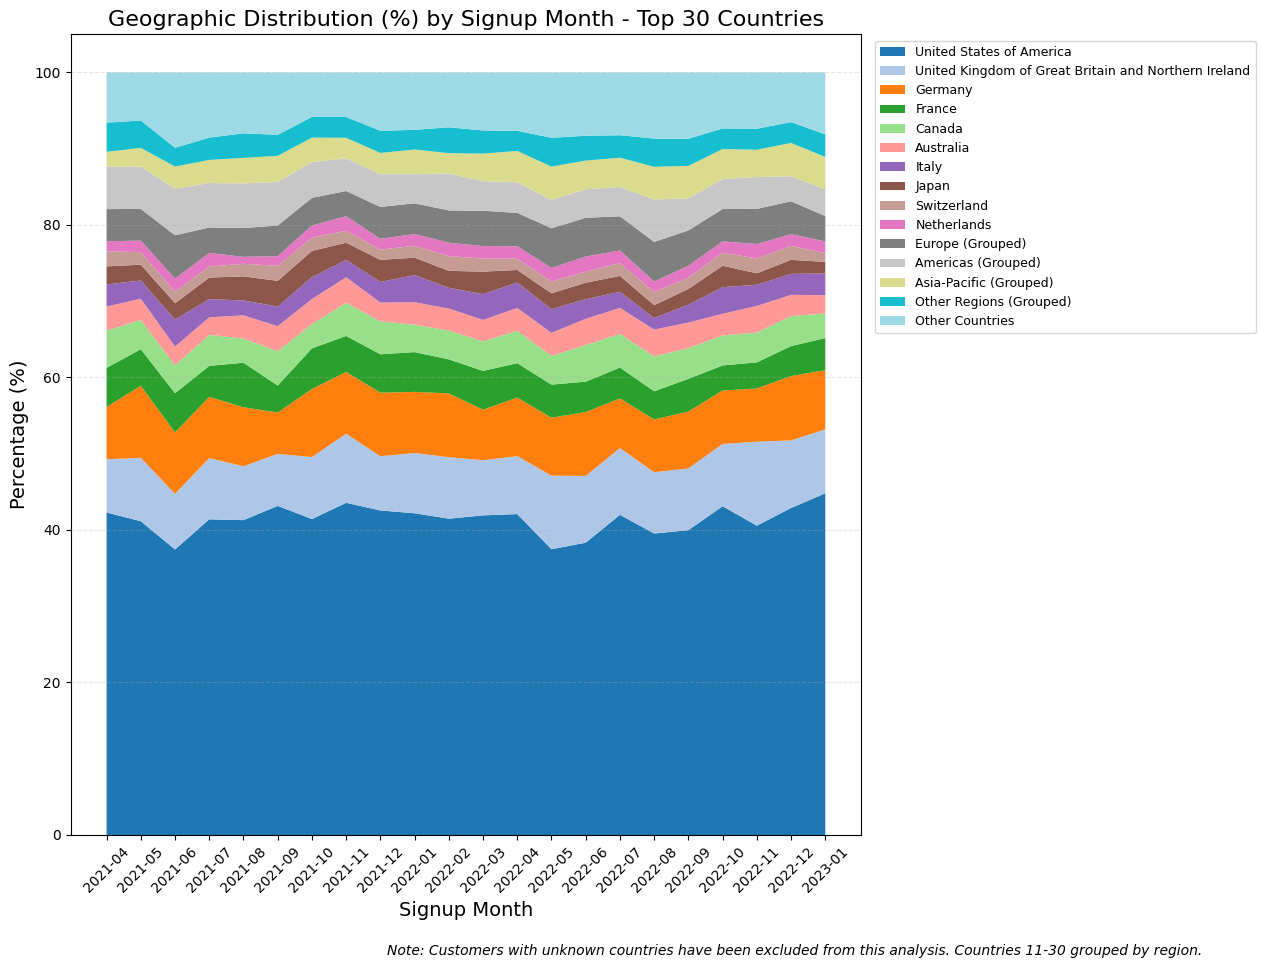

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Filter out entries with unknown countries
df_analysis = df_analysis[df_analysis['personal_person_geo_country'].notna() & 
                         (df_analysis['personal_person_geo_country'] != 'Unknown')]

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Identify top 30 countries by total MRR
country_mrr = df_analysis.groupby('personal_person_geo_country').apply(
    lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
).sort_values(ascending=False)

top_30_countries = country_mrr.head(30).index.tolist()
print(f"Analyzing top 30 countries by MRR")

# Create a DataFrame to store country distribution percentages by month
country_distribution = pd.DataFrame(index=all_months)

# Calculate customer counts by country and month
for country in top_30_countries:
    country_data = df_analysis[df_analysis['personal_person_geo_country'] == country]
    monthly_count = country_data.groupby('signup_month')['customer_count'].sum()
    country_distribution[country] = monthly_count

# Add "Other Countries" category
other_countries_data = df_analysis[~df_analysis['personal_person_geo_country'].isin(top_30_countries)]
other_monthly_count = other_countries_data.groupby('signup_month')['customer_count'].sum()
country_distribution['Other Countries'] = other_monthly_count

# Fill NaN values with 0
country_distribution = country_distribution.fillna(0)

# Calculate the total for each month
country_distribution['Total'] = country_distribution.sum(axis=1)

# Calculate percentages
percent_distribution = country_distribution.copy()
for col in country_distribution.columns:
    if col != 'Total':
        percent_distribution[col] = (country_distribution[col] / country_distribution['Total']) * 100



# Calculate unique countries count by month
unique_countries = []
for month in all_months:
    month_data = df_analysis[df_analysis['signup_month'] == month]
    unique_count = month_data['personal_person_geo_country'].nunique()
    unique_countries.append(unique_count)



# For visualization purposes, we'll group countries beyond the top 10 into regional groups
# First, get the top 10 countries
top_10_countries = top_30_countries[:10]

# Group remaining countries (11-30) by region or continent for visualization
# This is a simplified approach - in practice, you might want a more accurate regional grouping
def group_countries_by_region(countries):
    # This is a placeholder - in a real scenario, you'd have proper region mapping
    # You could use a package like pycountry or a custom mapping dictionary
    regions = {}
    for i, country in enumerate(countries):
        # Just creating artificial groups for this example
        region_idx = (i % 4)
        region_names = ["Europe", "Americas", "Asia-Pacific", "Other Regions"]
        region = region_names[region_idx]
        
        if region not in regions:
            regions[region] = []
        regions[region].append(country)
    
    return regions

# Group countries 11-30 by region
remaining_countries = top_30_countries[10:]
regional_groups = group_countries_by_region(remaining_countries)

# Create regional aggregates
for region, countries in regional_groups.items():
    regional_data = pd.DataFrame(index=all_months)
    for country in countries:
        if country in percent_distribution.columns:
            if region not in regional_data.columns:
                regional_data[region] = 0
            regional_data[region] += percent_distribution[country]
    
    # Only add non-empty regions
    if region in regional_data.columns:
        regional_data = regional_data.fillna(0)
        
        # Add to percent_distribution if it contains data
        if not regional_data[region].equals(pd.Series([0] * len(all_months))):
            percent_distribution[f"{region} (Grouped)"] = regional_data[region]

# Create a stacked area chart for percentage distribution with top 10 individually and others grouped
plt.figure(figsize=(16, 10))

# Prepare data for visualization - top 10 countries plus regional groups plus "Other Countries"
vis_columns = top_10_countries.copy()
for region in regional_groups.keys():
    vis_columns.append(f"{region} (Grouped)")
vis_columns.append("Other Countries")

# Filter columns that exist in the dataframe
vis_columns = [col for col in vis_columns if col in percent_distribution.columns]

# Create a color map with enough colors
colormap = plt.cm.tab20
colors = [colormap(i) for i in np.linspace(0, 1, len(vis_columns))]

# Create stacked area chart
plt.stackplot(range(len(all_months)), 
             [percent_distribution[country] for country in vis_columns],
             labels=vis_columns,
             colors=colors)

plt.title('Geographic Distribution (%) by Signup Month - Top 30 Countries', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(loc='upper left', fontsize=9, bbox_to_anchor=(1.01, 1))
plt.xticks(range(len(all_months)), all_months, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add note about unknown countries being filtered out
plt.figtext(0.5, 0.01, 'Note: Customers with unknown countries have been excluded from this analysis. Countries 11-30 grouped by region.',
           ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.03, 0.80, 0.97])  # Adjust for legend outside plot
plt.show()


### Takeaways on customer retention
- There is heavy churn in first three months 
- There seems to be a point at which churn improved going into 2022-01
    - This could be the start of longer term 1 year contract, would need to see if rentention dips more the next month 
    - Could also be something else about he product that changed
- Higher price tiers of average payment size seem to experience higher retention for longer 
    - Claim to be made to:
        1. Upsell customers harder or remove lower tiers
        2. Drive them into the tier which is seen as beneficial to customer
        3. Raise prices 
        4. Advertise to these possible higher tier customers (seems like they started to in )

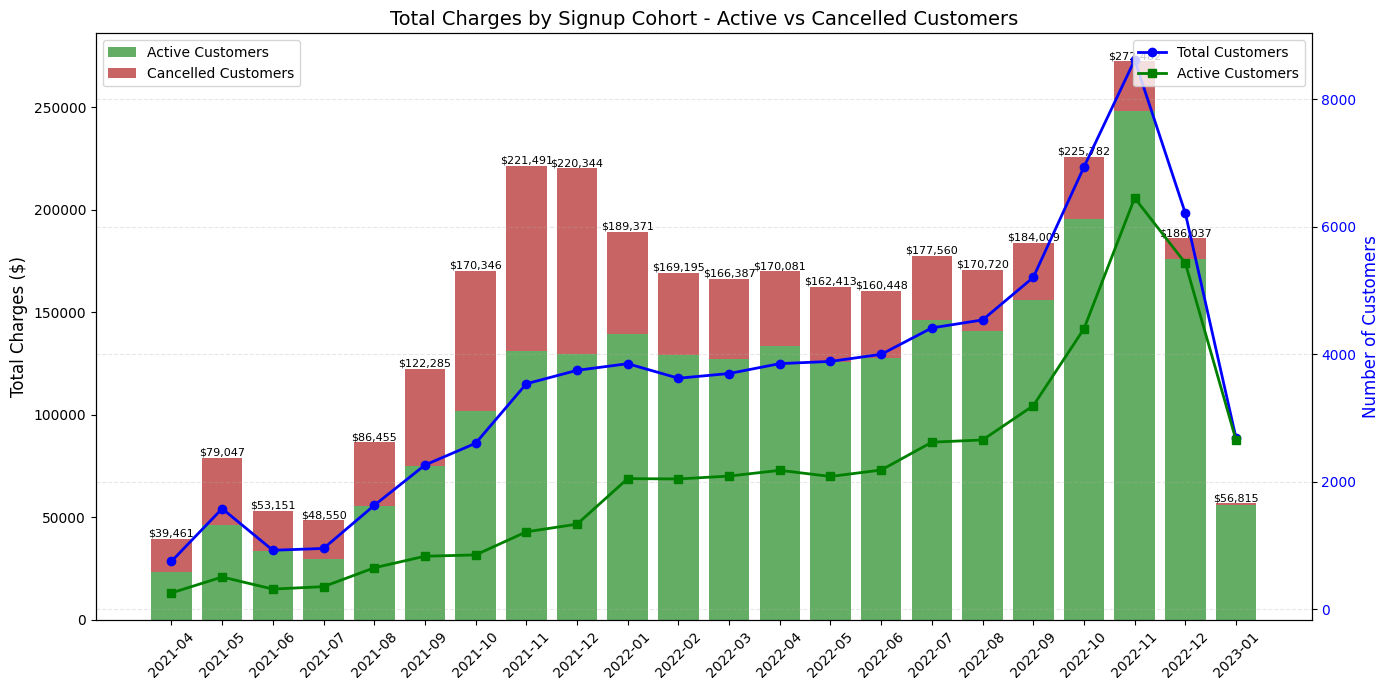

Total Charges by Signup Cohort (Active vs Cancelled):
   signup_cohort  total_charges  total_charges_active  \
0        2021-04       39460.54              23328.82   
1        2021-05       79047.38              45899.59   
2        2021-06       53151.06              33404.33   
3        2021-07       48550.30              29340.95   
4        2021-08       86455.02              55226.57   
5        2021-09      122285.16              74829.13   
6        2021-10      170346.22             101548.96   
7        2021-11      221490.70             131122.17   
8        2021-12      220343.67             129663.85   
9        2022-01      189370.79             139169.82   
10       2022-02      169194.53             129166.49   
11       2022-03      166387.06             127046.77   
12       2022-04      170081.26             133723.34   
13       2022-05      162412.57             125899.83   
14       2022-06      160448.37             127467.08   
15       2022-07      177559.91   

In [149]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['total_charges'] > 0)]

# Create separate dataframes for active and cancelled customers
active_customers = active_converted[active_converted['is_active'] == 1]
cancelled_customers = active_converted[active_converted['is_active'] == 0]

# Group by signup cohort for active customers
active_by_cohort = active_customers.groupby('signup_cohort').agg({
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Group by signup cohort for cancelled customers
cancelled_by_cohort = cancelled_customers.groupby('signup_cohort').agg({
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Sort by signup cohort
active_by_cohort = active_by_cohort.sort_values('signup_cohort')
cancelled_by_cohort = cancelled_by_cohort.sort_values('signup_cohort')

# Ensure all cohorts are in both dataframes (for proper stacking)
all_cohorts = sorted(list(set(active_converted['signup_cohort'].unique())))

for cohort in all_cohorts:
    if cohort not in active_by_cohort['signup_cohort'].values:
        active_by_cohort = active_by_cohort.append({
            'signup_cohort': cohort,
            'total_charges': 0,
            'oid': 0
        }, ignore_index=True)
    
    if cohort not in cancelled_by_cohort['signup_cohort'].values:
        cancelled_by_cohort = cancelled_by_cohort.append({
            'signup_cohort': cohort,
            'total_charges': 0,
            'oid': 0
        }, ignore_index=True)

# Re-sort after adding missing cohorts
active_by_cohort = active_by_cohort.sort_values('signup_cohort')
cancelled_by_cohort = cancelled_by_cohort.sort_values('signup_cohort')

# Create a stacked bar visualization of total charges by cohort
plt.figure(figsize=(14, 7))
ax1 = plt.subplot(111)

# Plot stacked bars for active and cancelled customers
bars_active = ax1.bar(active_by_cohort['signup_cohort'], active_by_cohort['total_charges'],
                     color='forestgreen', alpha=0.7, label='Active Customers')
bars_cancelled = ax1.bar(cancelled_by_cohort['signup_cohort'], cancelled_by_cohort['total_charges'],
                        bottom=active_by_cohort['total_charges'], color='firebrick', alpha=0.7, 
                        label='Cancelled Customers')

# Add labels and title
ax1.set_ylabel('Total Charges ($)', fontsize=12)
ax1.set_title('Total Charges by Signup Cohort - Active vs Cancelled Customers', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Add a second y-axis for customer count
ax2 = ax1.twinx()
ax2.plot(active_by_cohort['signup_cohort'], 
         active_by_cohort['oid'] + cancelled_by_cohort['oid'], 'o-',
         color='blue', linewidth=2, label='Total Customers')
ax2.plot(active_by_cohort['signup_cohort'], active_by_cohort['oid'], 's-',
         color='green', linewidth=2, label='Active Customers')
ax2.set_ylabel('Number of Customers', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

# Add value labels on top of stacked bars
for i, (active_bar, cancelled_bar) in enumerate(zip(bars_active, bars_cancelled)):
    active_height = active_bar.get_height()
    cancelled_height = cancelled_bar.get_height()
    total_height = active_height + cancelled_height
    
    if total_height > 0:  # Only add label if there are charges
        ax1.text(i, total_height, f'${total_height:,.0f}',
                ha='center', va='bottom', rotation=0, fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print the data
print("Total Charges by Signup Cohort (Active vs Cancelled):")
combined_data = pd.merge(active_by_cohort, cancelled_by_cohort, on='signup_cohort', suffixes=('_active', '_cancelled'))
combined_data['total_charges'] = combined_data['total_charges_active'] + combined_data['total_charges_cancelled']
combined_data['total_customers'] = combined_data['oid_active'] + combined_data['oid_cancelled']
combined_data['avg_charges_per_customer'] = combined_data['total_charges'] / combined_data['total_customers']
combined_data['avg_charges_per_customer'] = combined_data['avg_charges_per_customer'].round(2)

print(combined_data[['signup_cohort', 'total_charges', 'total_charges_active', 
                    'total_charges_cancelled', 'oid_active', 'oid_cancelled',
                    'avg_charges_per_customer']])

In [151]:
#converted_df = df[(df['converted'] == 1) & (df['is_canceled'] == 0)]
converted_df = df[(df['converted'] == 1) & (df['is_canceled'] == 0) ].copy()
# & (df['total_charges'] > 0) &  (df['current_mrr'] > 0)
converted_df['assumed_total_charges'] = converted_df['current_mrr'] * converted_df['payment_periods']
converted_df['delta'] = converted_df['total_charges'] - converted_df['assumed_total_charges']


avg_mrr_by_cohort = converted_df.groupby('signup_cohort').agg({
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',  # Including this for comparison
    'assumed_total_charges': 'mean',
    'total_charges': 'mean',
    'oid': 'count'
}).reset_index()

In [152]:
avg_mrr_by_cohort


,signup_cohort,current_mrr,avg_monthly_payment,assumed_total_charges,total_charges,oid
0,2021-04,4.102902,4.382418,86.007098,91.835608,255
1,2021-05,4.222461,4.404065,86.463613,90.091934,512
2,2021-06,4.118354,5.407394,79.944130,104.738540,322
3,2021-07,3.783109,4.544055,68.825574,82.647031,357
4,2021-08,3.919563,4.883322,67.365437,83.827274,664
5,2021-09,4.237239,5.473925,68.793033,88.969230,844
6,2021-10,5.952074,7.728669,91.082654,118.187370,863
7,2021-11,5.553214,7.828111,77.266218,106.814578,1232
8,2021-12,5.315870,7.478658,69.769484,95.917264,1356
9,2022-01,5.250085,5.444996,63.992216,66.176198,2107


In [153]:
converted_df2 = converted_df[converted_df['delta'] < 0]

In [154]:
avg_mrr_by_cohort2 = converted_df2.groupby('signup_cohort').agg({
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',  # Including this for comparison
    'assumed_total_charges': 'mean',
    'total_charges': 'mean',
    'delta': 'mean',
    'oid': 'count'
}).reset_index()

In [155]:
avg_mrr_by_cohort2


,signup_cohort,current_mrr,avg_monthly_payment,assumed_total_charges,total_charges,delta,oid
0,2021-04,7.461224,6.145497,156.359592,128.827143,-27.532449,49
1,2021-05,5.947967,5.061910,122.042527,103.870440,-18.172088,182
2,2021-06,7.024615,5.523300,138.232821,108.869487,-29.363333,39
3,2021-07,7.383714,4.825469,133.167429,86.411429,-46.756000,35
4,2021-08,7.254286,4.786034,125.208730,82.510476,-42.698254,63
5,2021-09,6.990606,4.916463,111.994949,79.472929,-32.522020,99
6,2021-10,7.961111,6.827549,121.220877,104.005848,-17.215029,171
7,2021-11,7.947558,6.573136,113.490000,94.595872,-18.894128,172
8,2021-12,7.337048,6.137104,97.494429,81.847286,-15.647143,210
9,2022-01,5.315745,4.870695,64.692174,59.303511,-5.388663,1182


In [156]:
print(converted_df[converted_df['delta'] < 0].shape[0])  # Count of customers with negative delta
print(converted_df[converted_df['delta'] >= 0].shape[0]) # Count of customers with negative delta


9279
38050


### Population above either experienced a free trial on the onset or expanded their subscription service at some point

In [159]:
avg_mrr_by_cohort2

,signup_cohort,current_mrr,avg_monthly_payment,assumed_total_charges,total_charges,delta,oid
0,2021-04,7.461224,6.145497,156.359592,128.827143,-27.532449,49
1,2021-05,5.947967,5.061910,122.042527,103.870440,-18.172088,182
2,2021-06,7.024615,5.523300,138.232821,108.869487,-29.363333,39
3,2021-07,7.383714,4.825469,133.167429,86.411429,-46.756000,35
4,2021-08,7.254286,4.786034,125.208730,82.510476,-42.698254,63
5,2021-09,6.990606,4.916463,111.994949,79.472929,-32.522020,99
6,2021-10,7.961111,6.827549,121.220877,104.005848,-17.215029,171
7,2021-11,7.947558,6.573136,113.490000,94.595872,-18.894128,172
8,2021-12,7.337048,6.137104,97.494429,81.847286,-15.647143,210
9,2022-01,5.315745,4.870695,64.692174,59.303511,-5.388663,1182
